# Larvae classification

## 1. Definitions

In [ ]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import accuracy_fn, cohen_kappa_fn, f1_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

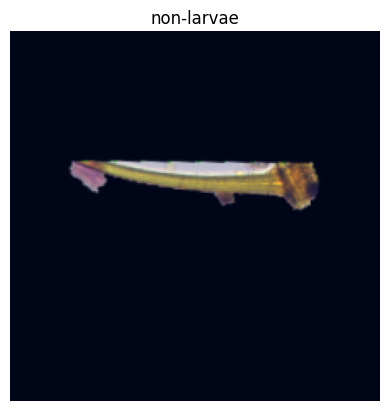

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

lr = 1e-4
eta_min=5e-7
weight_decay=1e-4
# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32,8],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_0 = optim.AdamW(cnn_0.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=eta_min)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6930 | Val Loss: 0.6924 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.7325 | Val roc_auc_fn: 0.7338
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6915 | Val Loss: 0.6902 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.7015 | Val roc_auc_fn: 0.6688
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6863 | Val Loss: 0.6818 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.7744 | Val roc_auc_fn: 0.7319
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6673 | Val Loss: 0.6554 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.8123 | Val roc_auc_fn: 0.8072
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6322 | Val Loss: 0.6108 | Train cohen_kappa_fn: 0.4863 | Val cohen_kappa_fn: 0.5176 | Train accuracy_fn: 0.8571 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.9143 | Val f1_fn: 0.9098 | Train roc_auc_fn: 0.8778 | Val roc_auc_fn: 0.9014
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5844 | Val Loss: 0.5460 | Train cohen_kappa_fn: 0.6196 | Val cohen_kappa_fn: 0.6944 | Train accuracy_fn: 0.9173 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9529 | Val f1_fn: 0.9606 | Train roc_auc_fn: 0.9272 | Val roc_auc_fn: 0.9396
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5426 | Val Loss: 0.5858 | Train cohen_kappa_fn: 0.5082 | Val cohen_kappa_fn: 0.4278 | Train accuracy_fn: 0.8095 | Val accuracy_fn: 0.7594 | Train f1_fn: 0.8738 | Val f1_fn: 0.8351 | Train roc_auc_fn: 0.9648 | Val roc_auc_fn: 0.9407
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.4797 | Val Loss: 0.4922 | Train cohen_kappa_fn: 0.6773 | Val cohen_kappa_fn: 0.5968 | Train accuracy_fn: 0.8960 | Val accuracy_fn: 0.8625 | Train f1_fn: 0.9351 | Val f1_fn: 0.9127 | Train roc_auc_fn: 0.9750 | Val roc_auc_fn: 0.9593
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4129 | Val Loss: 0.4011 | Train cohen_kappa_fn: 0.8285 | Val cohen_kappa_fn: 0.7531 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9724 | Val f1_fn: 0.9610 | Train roc_auc_fn: 0.9833 | Val roc_auc_fn: 0.9676
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3556 | Val Loss: 0.3385 | Train cohen_kappa_fn: 0.8449 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9745 | Val f1_fn: 0.9687 | Train roc_auc_fn: 0.9872 | Val roc_auc_fn: 0.9748
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3109 | Val Loss: 0.5564 | Train cohen_kappa_fn: 0.6842 | Val cohen_kappa_fn: 0.6319 | Train accuracy_fn: 0.9311 | Val accuracy_fn: 0.9187 | Train f1_fn: 0.9607 | Val f1_fn: 0.9536 | Train roc_auc_fn: 0.9755 | Val roc_auc_fn: 0.9545
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.3084 | Val Loss: 0.3389 | Train cohen_kappa_fn: 0.7896 | Val cohen_kappa_fn: 0.7464 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9709 | Val f1_fn: 0.9635 | Train roc_auc_fn: 0.9894 | Val roc_auc_fn: 0.9781
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2419 | Val Loss: 0.3637 | Train cohen_kappa_fn: 0.8283 | Val cohen_kappa_fn: 0.7006 | Train accuracy_fn: 0.9586 | Val accuracy_fn: 0.9281 | Train f1_fn: 0.9760 | Val f1_fn: 0.9583 | Train roc_auc_fn: 0.9885 | Val roc_auc_fn: 0.9780
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2307 | Val Loss: 0.2981 | Train cohen_kappa_fn: 0.8928 | Val cohen_kappa_fn: 0.7464 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9838 | Val f1_fn: 0.9635 | Train roc_auc_fn: 0.9904 | Val roc_auc_fn: 0.9811
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2195 | Val Loss: 0.5175 | Train cohen_kappa_fn: 0.2459 | Val cohen_kappa_fn: 0.2381 | Train accuracy_fn: 0.5890 | Val accuracy_fn: 0.5781 | Train f1_fn: 0.6791 | Val f1_fn: 0.6667 | Train roc_auc_fn: 0.9427 | Val roc_auc_fn: 0.9241
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2376 | Val Loss: 0.3744 | Train cohen_kappa_fn: 0.8862 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9438 | Train f1_fn: 0.9822 | Val f1_fn: 0.9670 | Train roc_auc_fn: 0.9894 | Val roc_auc_fn: 0.9733
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2194 | Val Loss: 0.1971 | Train cohen_kappa_fn: 0.7976 | Val cohen_kappa_fn: 0.7660 | Train accuracy_fn: 0.9398 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9633 | Val f1_fn: 0.9582 | Train roc_auc_fn: 0.9916 | Val roc_auc_fn: 0.9818
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2073 | Val Loss: 0.2007 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.7681 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9719 | Val f1_fn: 0.9605 | Train roc_auc_fn: 0.9917 | Val roc_auc_fn: 0.9790
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1861 | Val Loss: 0.1763 | Train cohen_kappa_fn: 0.7563 | Val cohen_kappa_fn: 0.7519 | Train accuracy_fn: 0.9236 | Val accuracy_fn: 0.9250 | Train f1_fn: 0.9527 | Val f1_fn: 0.9540 | Train roc_auc_fn: 0.9910 | Val roc_auc_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1485 | Val Loss: 0.1654 | Train cohen_kappa_fn: 0.8160 | Val cohen_kappa_fn: 0.8151 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9673 | Val f1_fn: 0.9679 | Train roc_auc_fn: 0.9926 | Val roc_auc_fn: 0.9841
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1947 | Val Loss: 0.1666 | Train cohen_kappa_fn: 0.8171 | Val cohen_kappa_fn: 0.7749 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9672 | Val f1_fn: 0.9602 | Train roc_auc_fn: 0.9919 | Val roc_auc_fn: 0.9839
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1810 | Val Loss: 0.2209 | Train cohen_kappa_fn: 0.9179 | Val cohen_kappa_fn: 0.7969 | Train accuracy_fn: 0.9774 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9865 | Val f1_fn: 0.9686 | Train roc_auc_fn: 0.9951 | Val roc_auc_fn: 0.9847
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1855 | Val Loss: 0.1799 | Train cohen_kappa_fn: 0.8905 | Val cohen_kappa_fn: 0.8496 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9594 | Train f1_fn: 0.9820 | Val f1_fn: 0.9758 | Train roc_auc_fn: 0.9930 | Val roc_auc_fn: 0.9859
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1672 | Val Loss: 0.1820 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8094 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9842 | Val f1_fn: 0.9681 | Train roc_auc_fn: 0.9949 | Val roc_auc_fn: 0.9853
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1607 | Val Loss: 0.1591 | Train cohen_kappa_fn: 0.8192 | Val cohen_kappa_fn: 0.7726 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9671 | Val f1_fn: 0.9579 | Train roc_auc_fn: 0.9944 | Val roc_auc_fn: 0.9851
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1608 | Val Loss: 0.2933 | Train cohen_kappa_fn: 0.9277 | Val cohen_kappa_fn: 0.8255 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9889 | Val f1_fn: 0.9744 | Train roc_auc_fn: 0.9960 | Val roc_auc_fn: 0.9869
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1938 | Val Loss: 0.2208 | Train cohen_kappa_fn: 0.9251 | Val cohen_kappa_fn: 0.8208 | Train accuracy_fn: 0.9799 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9881 | Val f1_fn: 0.9723 | Train roc_auc_fn: 0.9952 | Val roc_auc_fn: 0.9884
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1775 | Val Loss: 0.1482 | Train cohen_kappa_fn: 0.8436 | Val cohen_kappa_fn: 0.8344 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9727 | Val f1_fn: 0.9718 | Train roc_auc_fn: 0.9951 | Val roc_auc_fn: 0.9873
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1526 | Val Loss: 0.1799 | Train cohen_kappa_fn: 0.8746 | Val cohen_kappa_fn: 0.8292 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9789 | Val f1_fn: 0.9720 | Train roc_auc_fn: 0.9958 | Val roc_auc_fn: 0.9874
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1584 | Val Loss: 0.2218 | Train cohen_kappa_fn: 0.9438 | Val cohen_kappa_fn: 0.8285 | Train accuracy_fn: 0.9850 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9911 | Val f1_fn: 0.9743 | Train roc_auc_fn: 0.9953 | Val roc_auc_fn: 0.9881
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1636 | Val Loss: 0.2061 | Train cohen_kappa_fn: 0.9033 | Val cohen_kappa_fn: 0.8554 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9625 | Train f1_fn: 0.9843 | Val f1_fn: 0.9779 | Train roc_auc_fn: 0.9959 | Val roc_auc_fn: 0.9876
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1630 | Val Loss: 0.2807 | Train cohen_kappa_fn: 0.9196 | Val cohen_kappa_fn: 0.8285 | Train accuracy_fn: 0.9787 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9874 | Val f1_fn: 0.9743 | Train roc_auc_fn: 0.9960 | Val roc_auc_fn: 0.9862
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1280 | Val Loss: 0.1432 | Train cohen_kappa_fn: 0.8229 | Val cohen_kappa_fn: 0.7933 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9679 | Val f1_fn: 0.9617 | Train roc_auc_fn: 0.9956 | Val roc_auc_fn: 0.9875
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.1459 | Val Loss: 0.2422 | Train cohen_kappa_fn: 0.9336 | Val cohen_kappa_fn: 0.8394 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9594 | Train f1_fn: 0.9896 | Val f1_fn: 0.9761 | Train roc_auc_fn: 0.9954 | Val roc_auc_fn: 0.9883
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1313 | Val Loss: 0.1638 | Train cohen_kappa_fn: 0.8761 | Val cohen_kappa_fn: 0.8542 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9594 | Train f1_fn: 0.9789 | Val f1_fn: 0.9756 | Train roc_auc_fn: 0.9963 | Val roc_auc_fn: 0.9873
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1144 | Val Loss: 0.1838 | Train cohen_kappa_fn: 0.8912 | Val cohen_kappa_fn: 0.8265 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9820 | Val f1_fn: 0.9721 | Train roc_auc_fn: 0.9961 | Val roc_auc_fn: 0.9873
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1843 | Val Loss: 0.1753 | Train cohen_kappa_fn: 0.9309 | Val cohen_kappa_fn: 0.8265 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9888 | Val f1_fn: 0.9721 | Train roc_auc_fn: 0.9960 | Val roc_auc_fn: 0.9877
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1556 | Val Loss: 0.1972 | Train cohen_kappa_fn: 0.9082 | Val cohen_kappa_fn: 0.8237 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9531 | Train f1_fn: 0.9850 | Val f1_fn: 0.9722 | Train roc_auc_fn: 0.9960 | Val roc_auc_fn: 0.9887
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


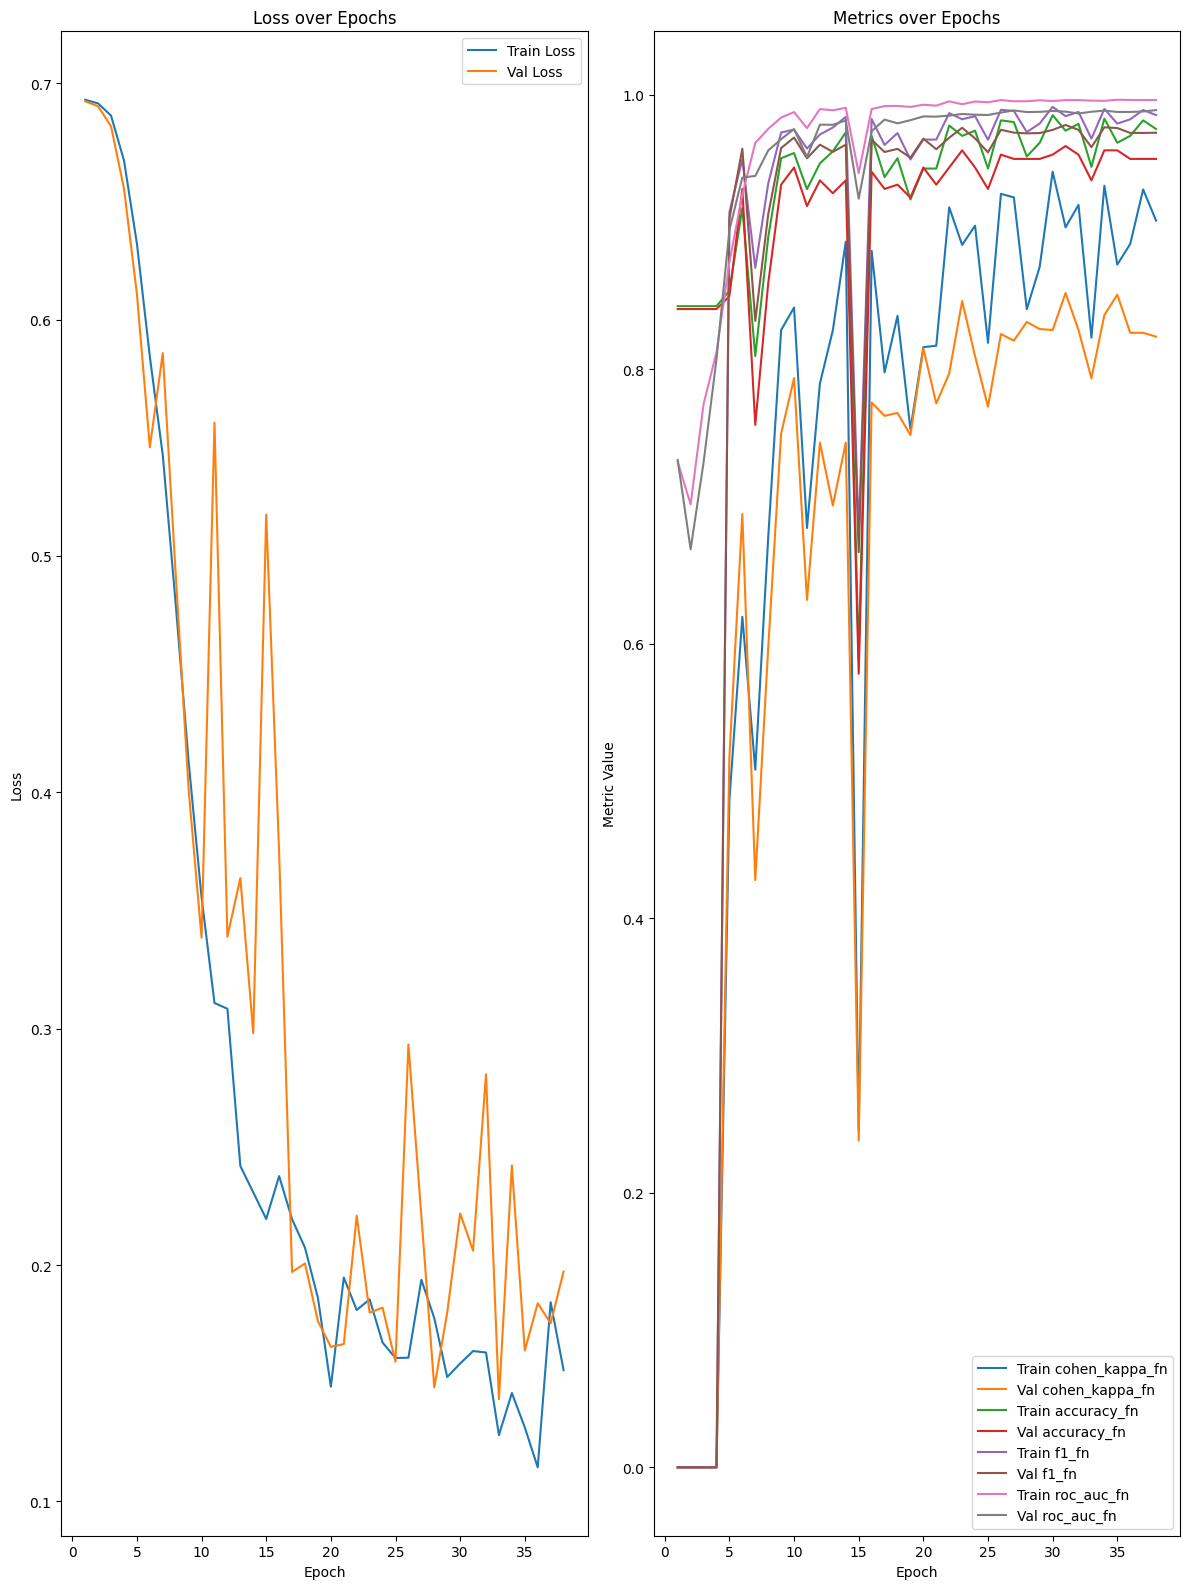

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1240 | Test cohen_kappa_fn: 0.8337 | Test accuracy_fn: 0.9521 | Test f1_fn: 0.9710 | Test roc_auc_fn: 0.9907


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

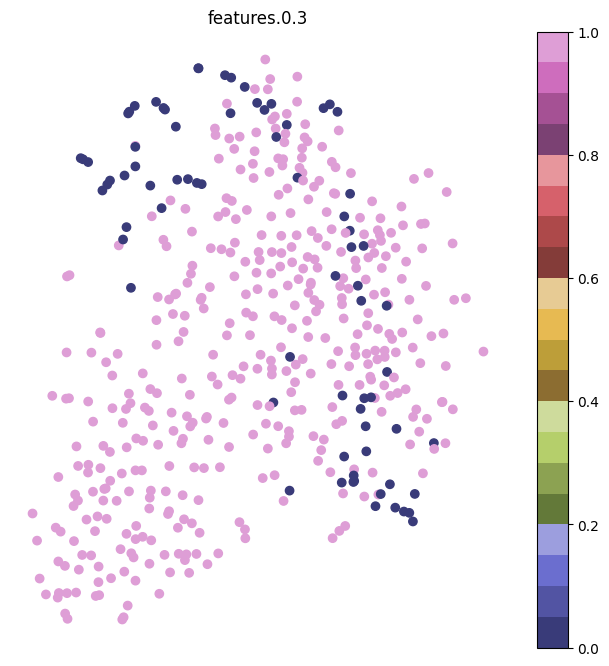

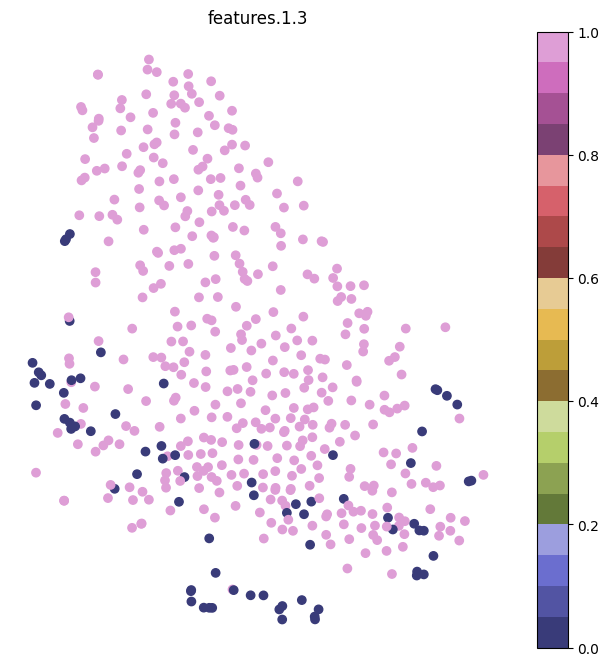

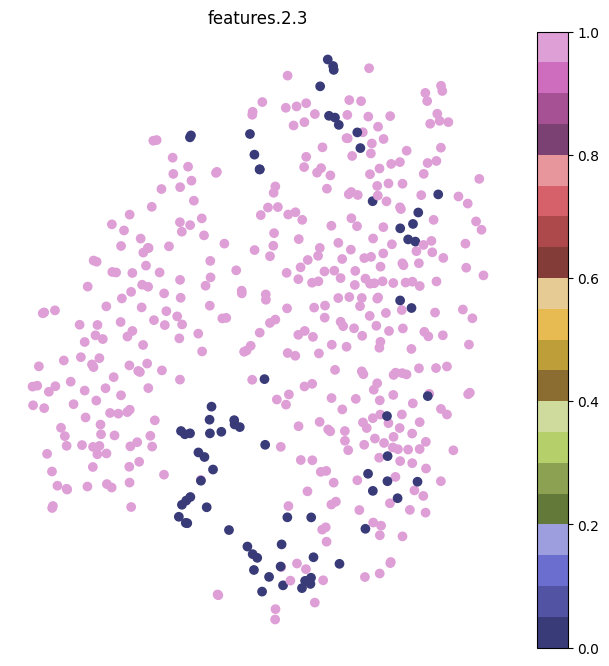

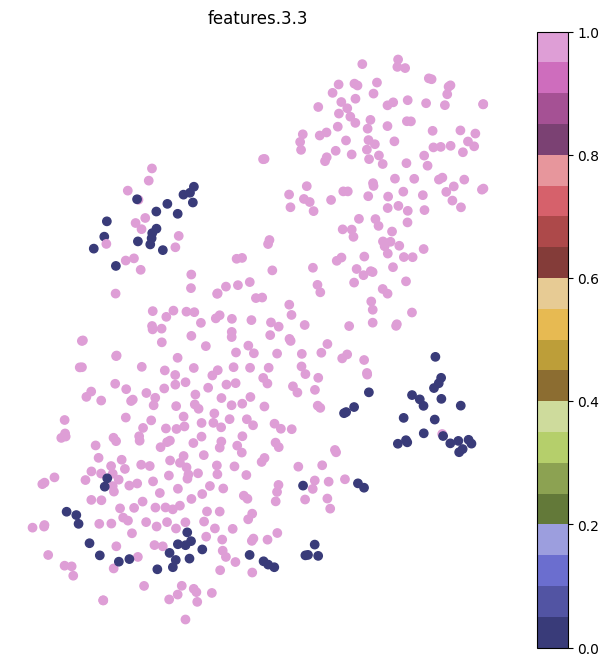

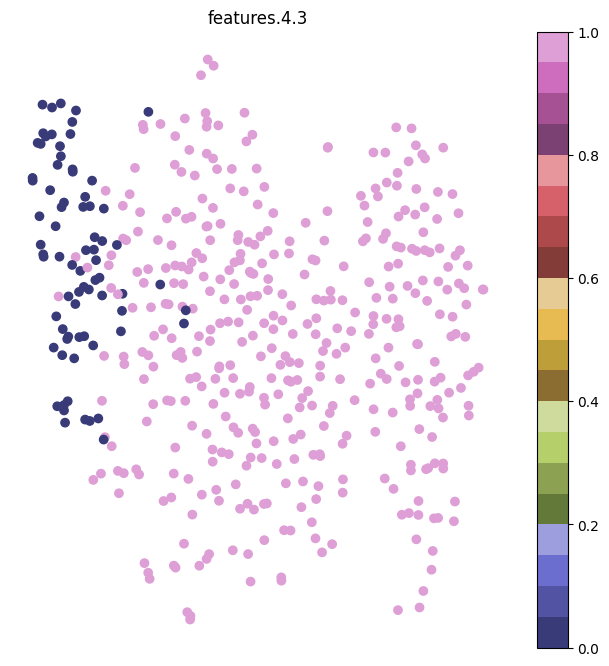

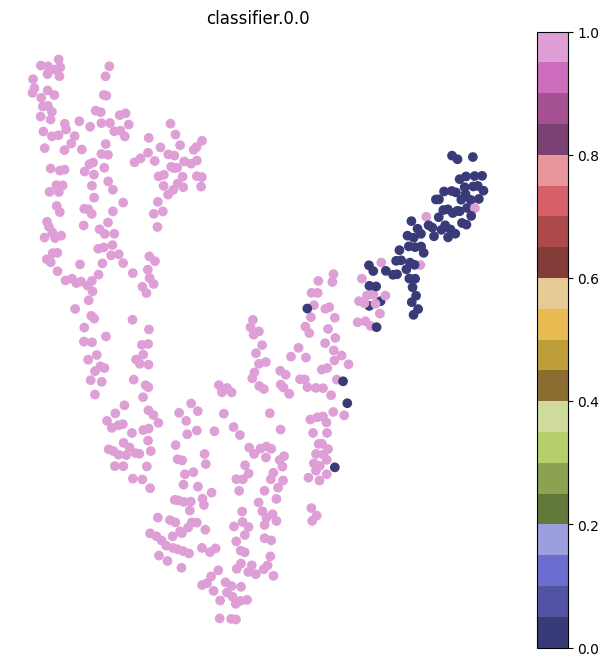

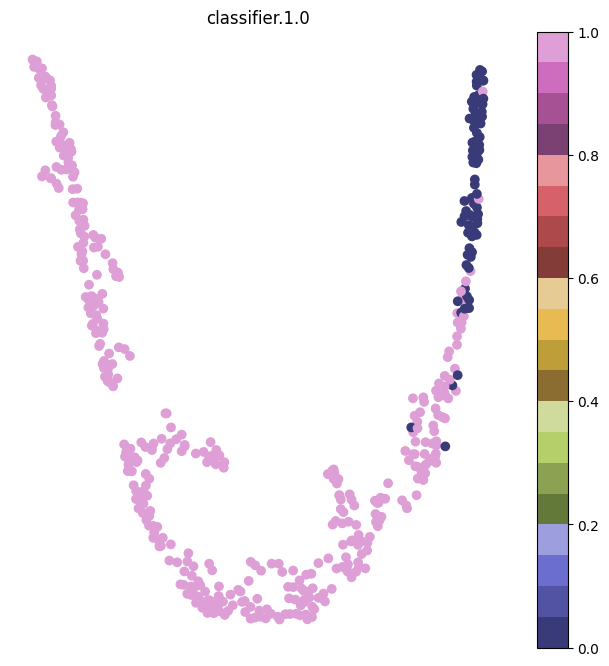

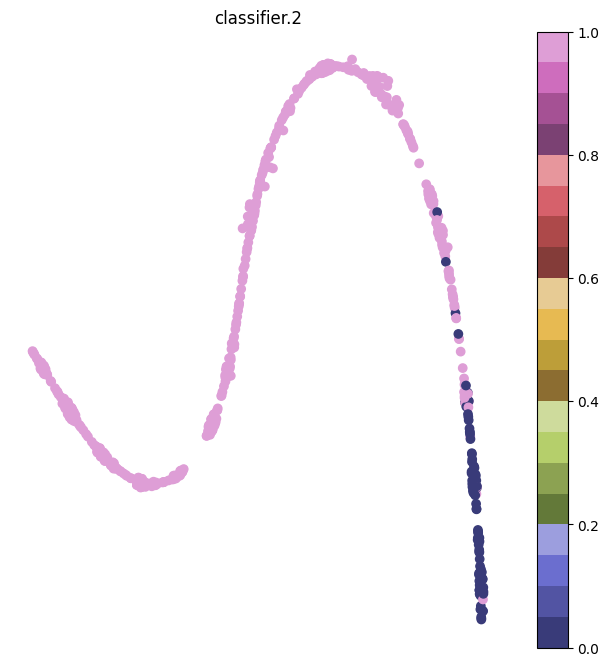

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


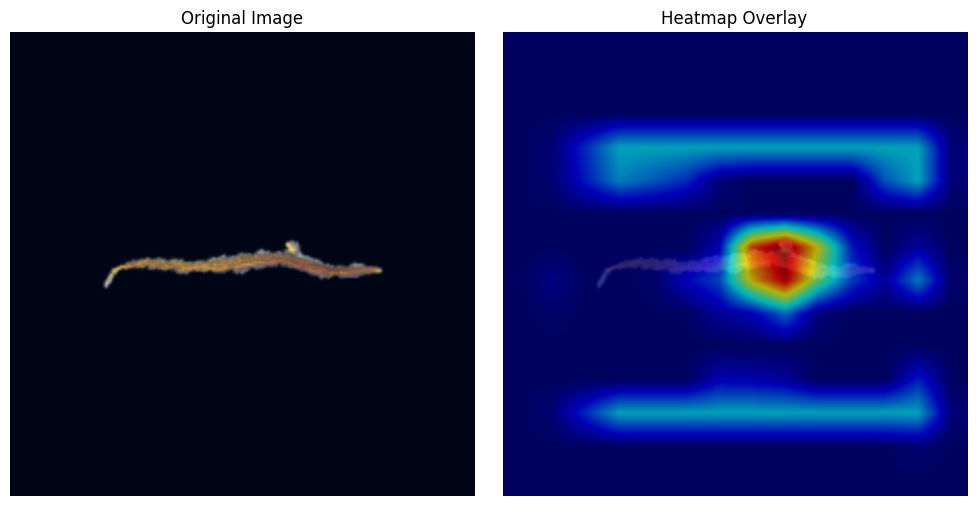

  Generating heatmap for Larvae...
  Predicted label is Larvae!


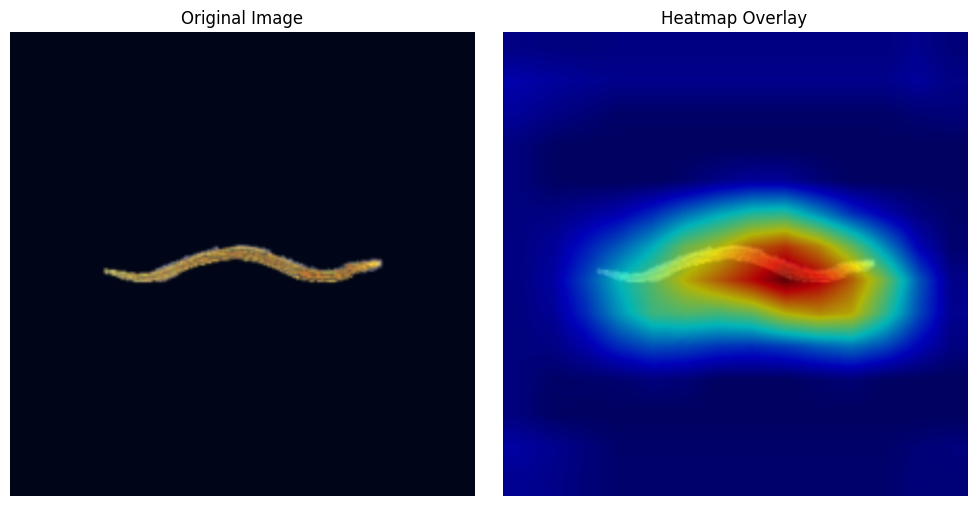

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32,16],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=eta_min)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6909 | Val Loss: 0.6886 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.6122 | Val roc_auc_fn: 0.5684
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6858 | Val Loss: 0.6830 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.6751 | Val roc_auc_fn: 0.6214
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6712 | Val Loss: 0.6582 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.7577 | Val roc_auc_fn: 0.7353
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6328 | Val Loss: 0.6121 | Train cohen_kappa_fn: 0.3834 | Val cohen_kappa_fn: 0.4093 | Train accuracy_fn: 0.8371 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.9034 | Val f1_fn: 0.9141 | Train roc_auc_fn: 0.8374 | Val roc_auc_fn: 0.8324
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5919 | Val Loss: 0.5701 | Train cohen_kappa_fn: 0.5158 | Val cohen_kappa_fn: 0.4903 | Train accuracy_fn: 0.8960 | Val accuracy_fn: 0.8875 | Train f1_fn: 0.9408 | Val f1_fn: 0.9357 | Train roc_auc_fn: 0.8812 | Val roc_auc_fn: 0.8776
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5589 | Val Loss: 0.5746 | Train cohen_kappa_fn: 0.3881 | Val cohen_kappa_fn: 0.3937 | Train accuracy_fn: 0.7381 | Val accuracy_fn: 0.7437 | Train f1_fn: 0.8194 | Val f1_fn: 0.8240 | Train roc_auc_fn: 0.9222 | Val roc_auc_fn: 0.9071
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4679 | Val Loss: 0.4626 | Train cohen_kappa_fn: 0.8135 | Val cohen_kappa_fn: 0.7475 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9692 | Val f1_fn: 0.9590 | Train roc_auc_fn: 0.9690 | Val roc_auc_fn: 0.9364
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3947 | Val Loss: 0.5193 | Train cohen_kappa_fn: 0.7634 | Val cohen_kappa_fn: 0.6319 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9187 | Train f1_fn: 0.9682 | Val f1_fn: 0.9536 | Train roc_auc_fn: 0.9755 | Val roc_auc_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3662 | Val Loss: 0.6434 | Train cohen_kappa_fn: 0.7534 | Val cohen_kappa_fn: 0.5875 | Train accuracy_fn: 0.9436 | Val accuracy_fn: 0.9125 | Train f1_fn: 0.9676 | Val f1_fn: 0.9504 | Train roc_auc_fn: 0.9788 | Val roc_auc_fn: 0.9445
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2733 | Val Loss: 0.3248 | Train cohen_kappa_fn: 0.4532 | Val cohen_kappa_fn: 0.5666 | Train accuracy_fn: 0.7707 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.8432 | Val f1_fn: 0.9069 | Train roc_auc_fn: 0.9707 | Val roc_auc_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2505 | Val Loss: 0.2800 | Train cohen_kappa_fn: 0.5190 | Val cohen_kappa_fn: 0.6706 | Train accuracy_fn: 0.8145 | Val accuracy_fn: 0.8969 | Train f1_fn: 0.8773 | Val f1_fn: 0.9362 | Train roc_auc_fn: 0.9770 | Val roc_auc_fn: 0.9549
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2712 | Val Loss: 0.3338 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7449 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9682 | Val f1_fn: 0.9613 | Train roc_auc_fn: 0.9872 | Val roc_auc_fn: 0.9567
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2191 | Val Loss: 0.3170 | Train cohen_kappa_fn: 0.8477 | Val cohen_kappa_fn: 0.7590 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9744 | Val f1_fn: 0.9631 | Train roc_auc_fn: 0.9886 | Val roc_auc_fn: 0.9615
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2226 | Val Loss: 0.2830 | Train cohen_kappa_fn: 0.4345 | Val cohen_kappa_fn: 0.5531 | Train accuracy_fn: 0.7594 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.8345 | Val f1_fn: 0.9000 | Train roc_auc_fn: 0.9729 | Val roc_auc_fn: 0.9573
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1835 | Val Loss: 0.6177 | Train cohen_kappa_fn: 0.8974 | Val cohen_kappa_fn: 0.6944 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9845 | Val f1_fn: 0.9606 | Train roc_auc_fn: 0.9890 | Val roc_auc_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1589 | Val Loss: 0.2972 | Train cohen_kappa_fn: 0.6533 | Val cohen_kappa_fn: 0.7421 | Train accuracy_fn: 0.8835 | Val accuracy_fn: 0.9281 | Train f1_fn: 0.9264 | Val f1_fn: 0.9568 | Train roc_auc_fn: 0.9865 | Val roc_auc_fn: 0.9599
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


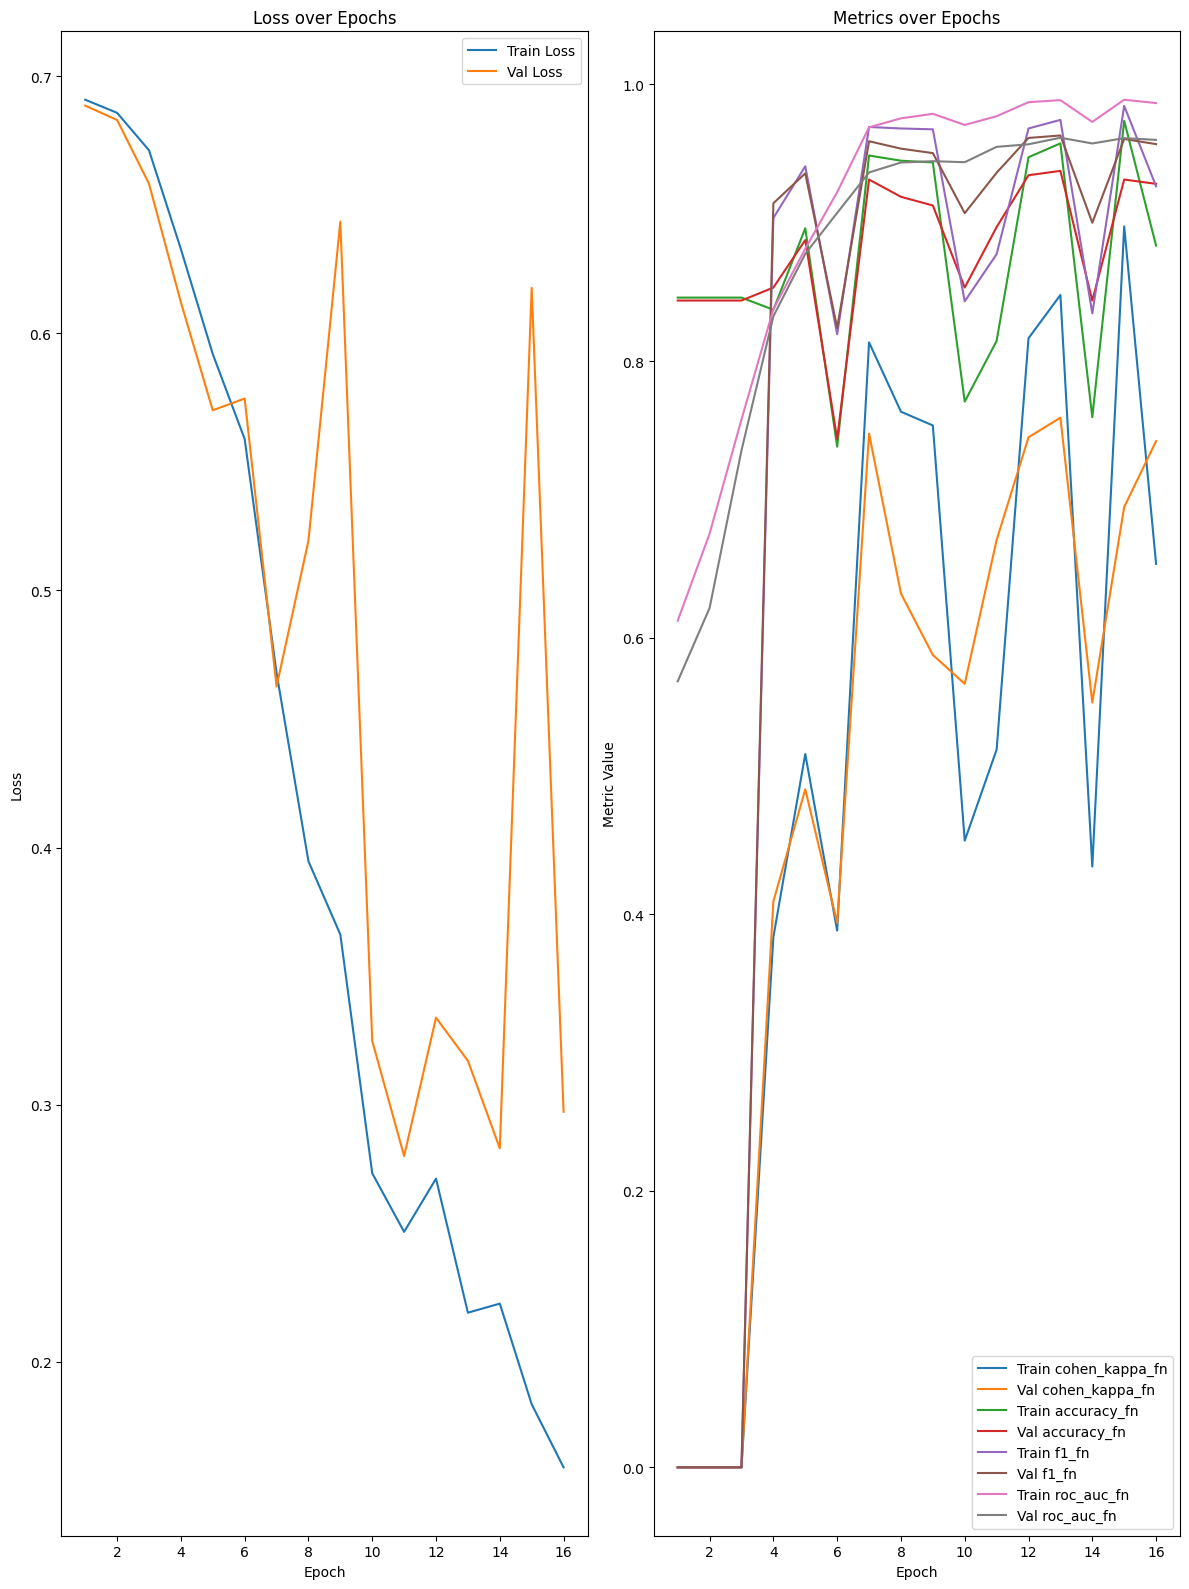

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2497 | Test cohen_kappa_fn: 0.6628 | Test accuracy_fn: 0.8917 | Test f1_fn: 0.9325 | Test roc_auc_fn: 0.9672


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

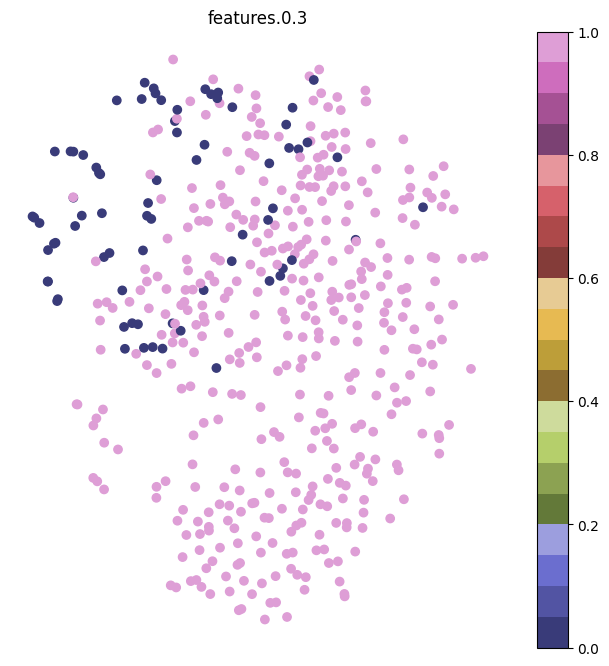

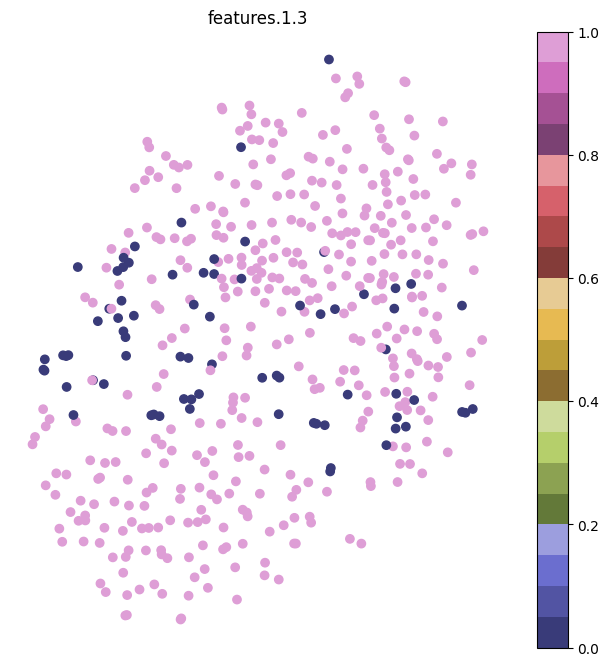

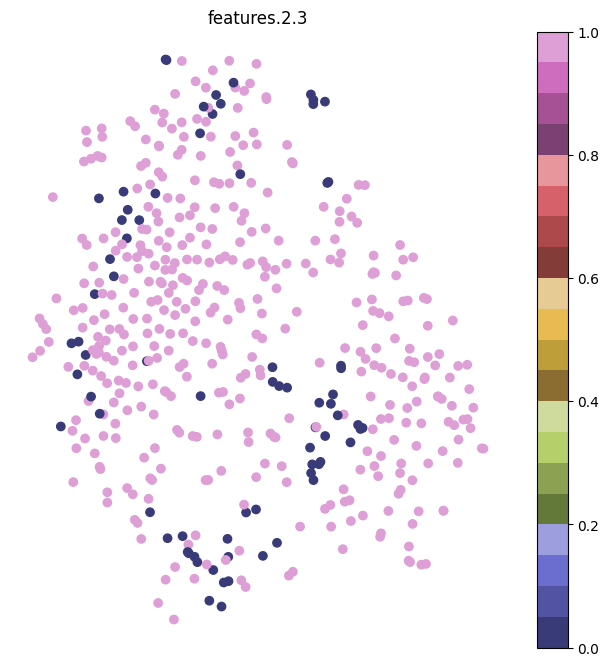

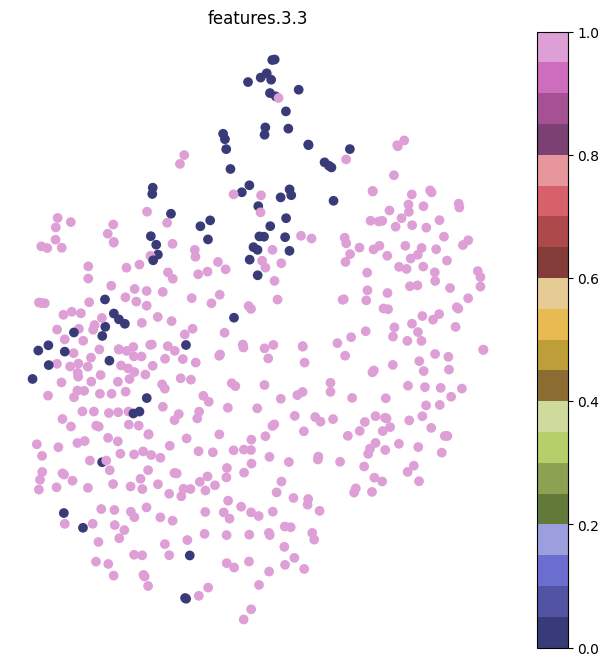

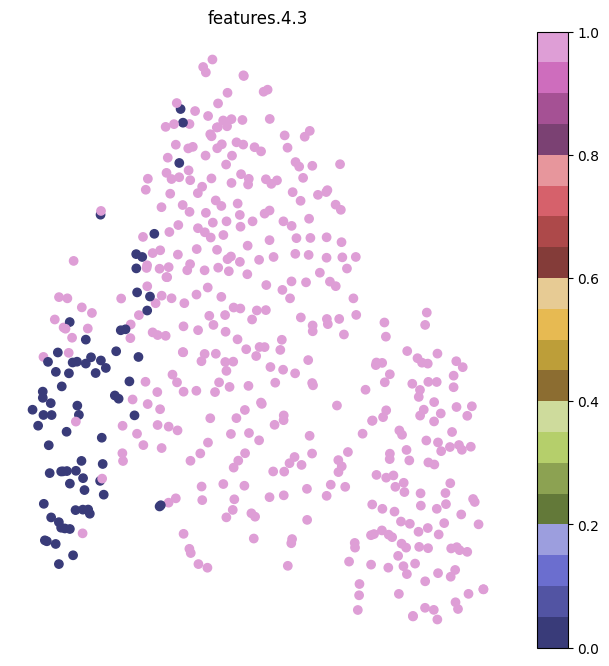

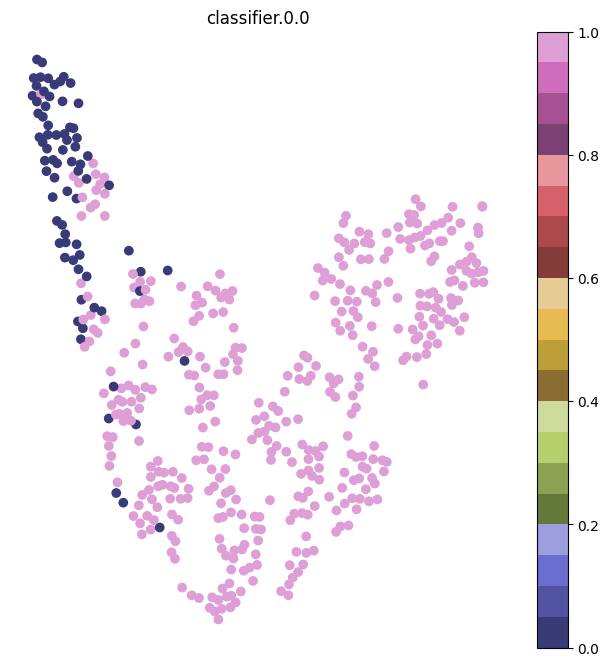

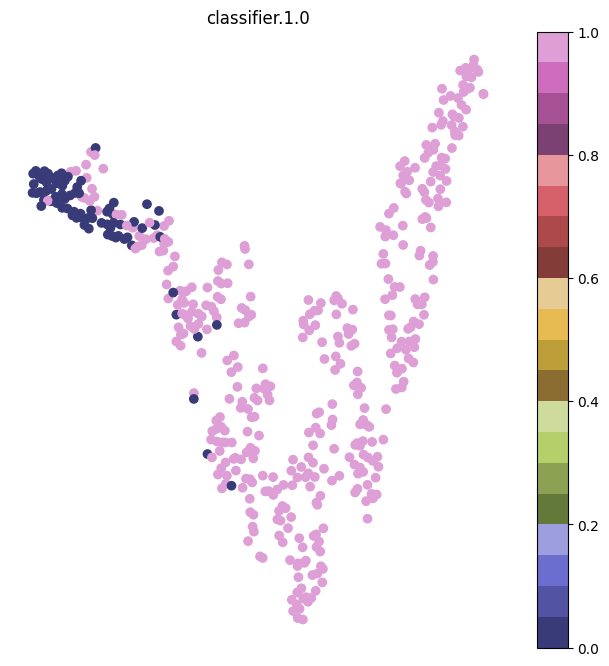

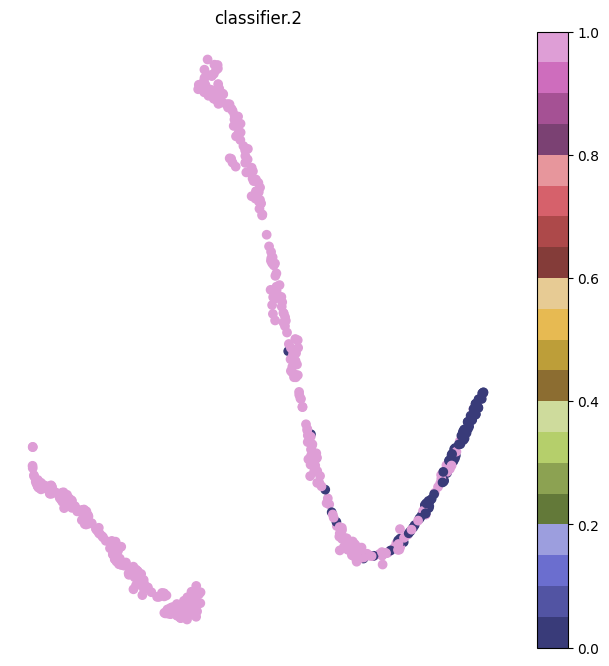

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


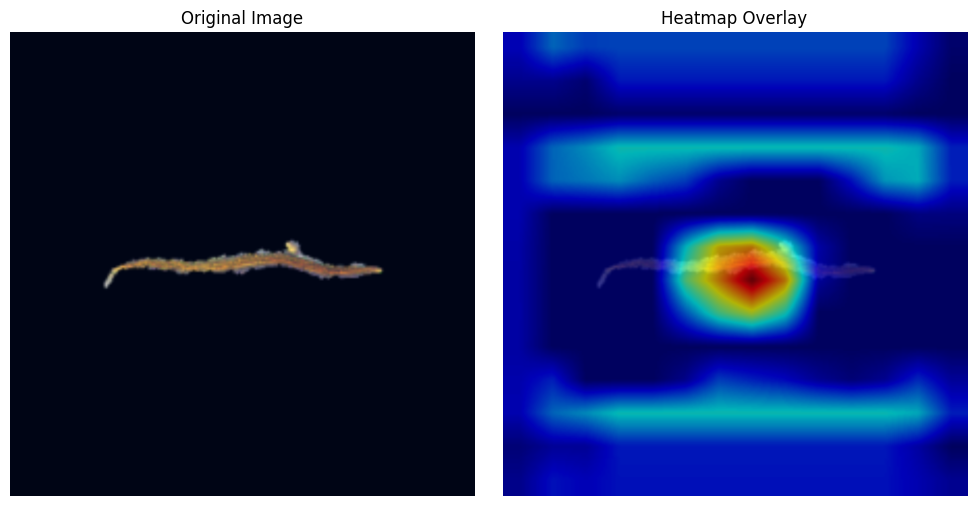

  Generating heatmap for Larvae...
  Predicted label is Larvae!


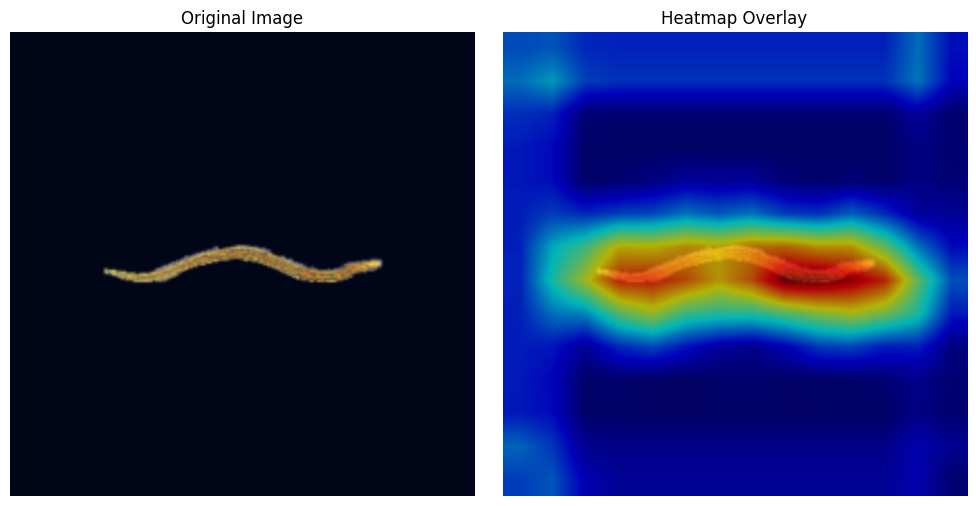

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=eta_min)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6930 | Val Loss: 0.6927 | Train cohen_kappa_fn: 0.1958 | Val cohen_kappa_fn: 0.1230 | Train accuracy_fn: 0.5965 | Val accuracy_fn: 0.5125 | Train f1_fn: 0.6996 | Val f1_fn: 0.6139 | Train roc_auc_fn: 0.7937 | Val roc_auc_fn: 0.6775
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6924 | Val Loss: 0.6918 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.7031 | Val roc_auc_fn: 0.6018
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6893 | Val Loss: 0.6881 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000 | Train roc_auc_fn: 0.8144 | Val roc_auc_fn: 0.7510
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6801 | Val Loss: 0.6700 | Train cohen_kappa_fn: 0.3484 | Val cohen_kappa_fn: 0.3449 | Train accuracy_fn: 0.7318 | Val accuracy_fn: 0.7063 | Train f1_fn: 0.8180 | Val f1_fn: 0.7930 | Train roc_auc_fn: 0.8841 | Val roc_auc_fn: 0.8956
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6462 | Val Loss: 0.6208 | Train cohen_kappa_fn: 0.3143 | Val cohen_kappa_fn: 0.2403 | Train accuracy_fn: 0.6779 | Val accuracy_fn: 0.5875 | Train f1_fn: 0.7683 | Val f1_fn: 0.6780 | Train roc_auc_fn: 0.9147 | Val roc_auc_fn: 0.9224
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5611 | Val Loss: 0.4690 | Train cohen_kappa_fn: 0.5214 | Val cohen_kappa_fn: 0.4451 | Train accuracy_fn: 0.8271 | Val accuracy_fn: 0.7750 | Train f1_fn: 0.8882 | Val f1_fn: 0.8481 | Train roc_auc_fn: 0.9431 | Val roc_auc_fn: 0.9473
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4251 | Val Loss: 0.3773 | Train cohen_kappa_fn: 0.5124 | Val cohen_kappa_fn: 0.4291 | Train accuracy_fn: 0.8145 | Val accuracy_fn: 0.7563 | Train f1_fn: 0.8779 | Val f1_fn: 0.8319 | Train roc_auc_fn: 0.9566 | Val roc_auc_fn: 0.9565
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3379 | Val Loss: 0.3086 | Train cohen_kappa_fn: 0.6946 | Val cohen_kappa_fn: 0.7508 | Train accuracy_fn: 0.9286 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9587 | Val f1_fn: 0.9634 | Train roc_auc_fn: 0.9429 | Val roc_auc_fn: 0.9671
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2890 | Val Loss: 0.3296 | Train cohen_kappa_fn: 0.5300 | Val cohen_kappa_fn: 0.4437 | Train accuracy_fn: 0.8208 | Val accuracy_fn: 0.7625 | Train f1_fn: 0.8819 | Val f1_fn: 0.8362 | Train roc_auc_fn: 0.9732 | Val roc_auc_fn: 0.9713
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2556 | Val Loss: 0.3354 | Train cohen_kappa_fn: 0.7867 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9438 | Train f1_fn: 0.9701 | Val f1_fn: 0.9672 | Train roc_auc_fn: 0.9730 | Val roc_auc_fn: 0.9790
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2487 | Val Loss: 0.4161 | Train cohen_kappa_fn: 0.3783 | Val cohen_kappa_fn: 0.3506 | Train accuracy_fn: 0.7155 | Val accuracy_fn: 0.6906 | Train f1_fn: 0.7979 | Val f1_fn: 0.7755 | Train roc_auc_fn: 0.9788 | Val roc_auc_fn: 0.9640
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2338 | Val Loss: 0.5432 | Train cohen_kappa_fn: 0.6369 | Val cohen_kappa_fn: 0.6245 | Train accuracy_fn: 0.9223 | Val accuracy_fn: 0.9187 | Train f1_fn: 0.9558 | Val f1_fn: 0.9537 | Train roc_auc_fn: 0.9658 | Val roc_auc_fn: 0.9644
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2045 | Val Loss: 0.2515 | Train cohen_kappa_fn: 0.8778 | Val cohen_kappa_fn: 0.7795 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9438 | Train f1_fn: 0.9815 | Val f1_fn: 0.9669 | Train roc_auc_fn: 0.9913 | Val roc_auc_fn: 0.9829
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2331 | Val Loss: 0.3223 | Train cohen_kappa_fn: 0.8753 | Val cohen_kappa_fn: 0.7570 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9406 | Train f1_fn: 0.9816 | Val f1_fn: 0.9654 | Train roc_auc_fn: 0.9897 | Val roc_auc_fn: 0.9847
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1923 | Val Loss: 0.1882 | Train cohen_kappa_fn: 0.6961 | Val cohen_kappa_fn: 0.7268 | Train accuracy_fn: 0.9010 | Val accuracy_fn: 0.9156 | Train f1_fn: 0.9380 | Val f1_fn: 0.9480 | Train roc_auc_fn: 0.9852 | Val roc_auc_fn: 0.9808
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1915 | Val Loss: 0.1943 | Train cohen_kappa_fn: 0.6887 | Val cohen_kappa_fn: 0.6659 | Train accuracy_fn: 0.8972 | Val accuracy_fn: 0.8875 | Train f1_fn: 0.9354 | Val f1_fn: 0.9289 | Train roc_auc_fn: 0.9883 | Val roc_auc_fn: 0.9828
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1816 | Val Loss: 0.1446 | Train cohen_kappa_fn: 0.8149 | Val cohen_kappa_fn: 0.8247 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9500 | Train f1_fn: 0.9673 | Val f1_fn: 0.9698 | Train roc_auc_fn: 0.9901 | Val roc_auc_fn: 0.9837
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1597 | Val Loss: 0.1563 | Train cohen_kappa_fn: 0.8738 | Val cohen_kappa_fn: 0.8418 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9789 | Val f1_fn: 0.9738 | Train roc_auc_fn: 0.9938 | Val roc_auc_fn: 0.9847
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1442 | Val Loss: 0.1518 | Train cohen_kappa_fn: 0.8171 | Val cohen_kappa_fn: 0.7726 | Train accuracy_fn: 0.9461 | Val accuracy_fn: 0.9312 | Train f1_fn: 0.9672 | Val f1_fn: 0.9579 | Train roc_auc_fn: 0.9918 | Val roc_auc_fn: 0.9847
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1424 | Val Loss: 0.1479 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.8151 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9648 | Val f1_fn: 0.9679 | Train roc_auc_fn: 0.9929 | Val roc_auc_fn: 0.9845
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1384 | Val Loss: 0.1522 | Train cohen_kappa_fn: 0.8523 | Val cohen_kappa_fn: 0.8247 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9500 | Train f1_fn: 0.9742 | Val f1_fn: 0.9698 | Train roc_auc_fn: 0.9944 | Val roc_auc_fn: 0.9852
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1215 | Val Loss: 0.1551 | Train cohen_kappa_fn: 0.8514 | Val cohen_kappa_fn: 0.8442 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9742 | Val f1_fn: 0.9737 | Train roc_auc_fn: 0.9922 | Val roc_auc_fn: 0.9845
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


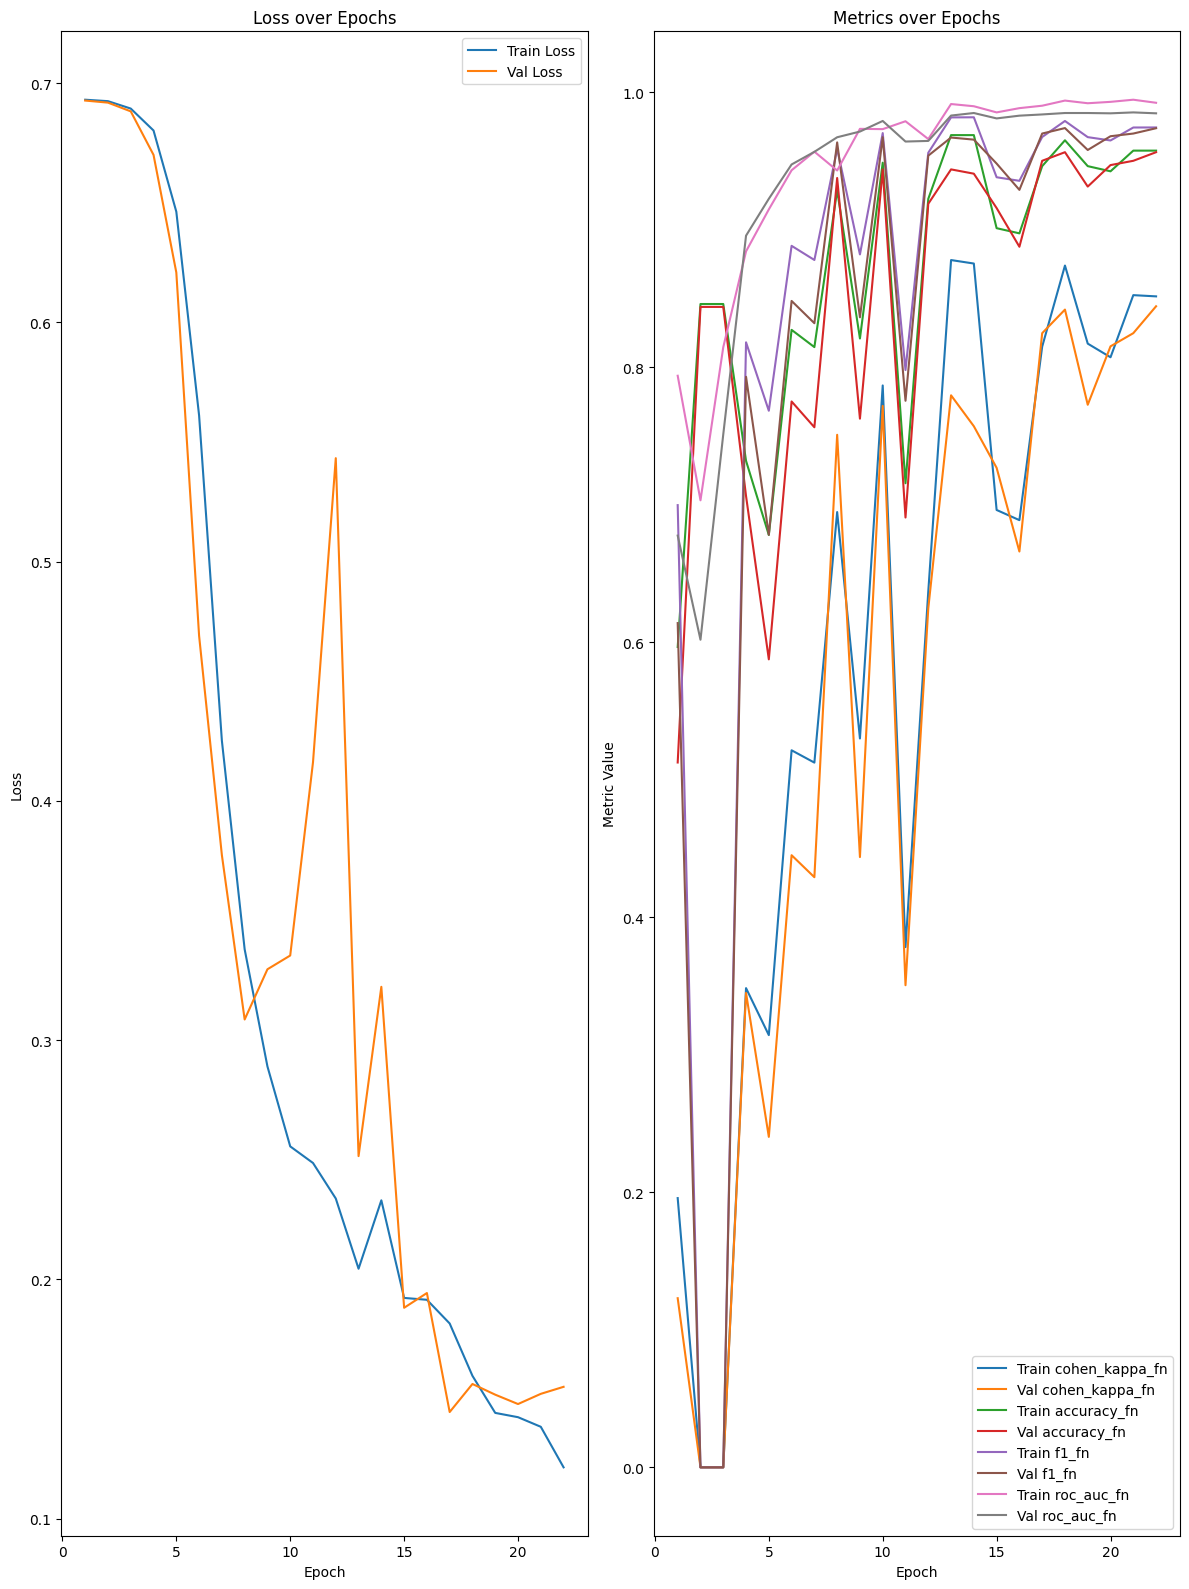

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1508 | Test cohen_kappa_fn: 0.8352 | Test accuracy_fn: 0.9542 | Test f1_fn: 0.9725 | Test roc_auc_fn: 0.9865


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [32]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

KeyboardInterrupt: 

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


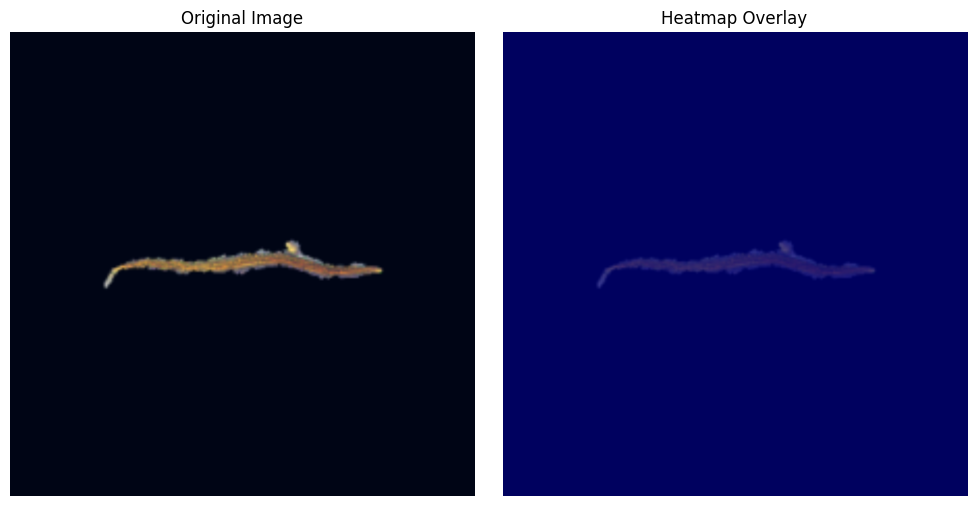

  Generating heatmap for Larvae...
  Predicted label is Larvae!


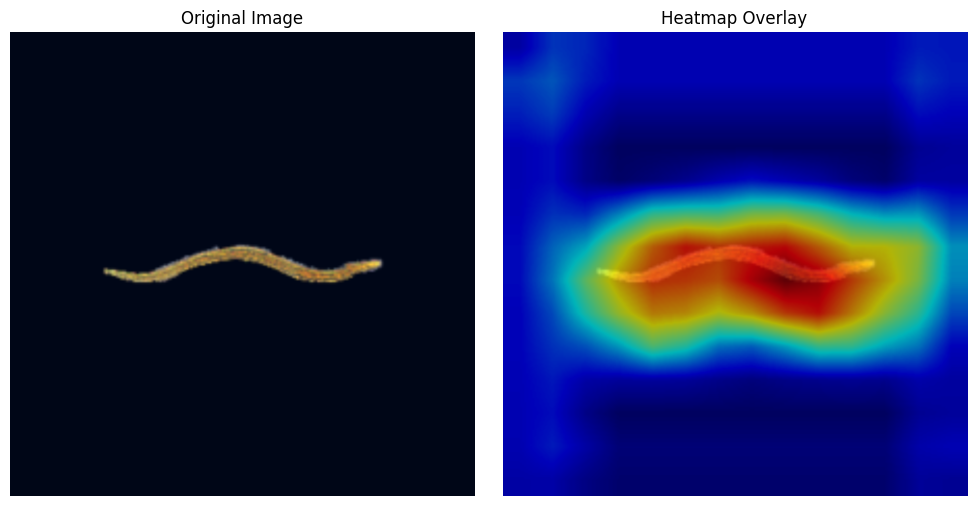

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [ ]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,16],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=eta_min)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6918 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.1541 | Val accuracy_fn: 0.1562
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6904 | Val Loss: 0.6877 | Train cohen_kappa_fn: 0.0005 | Val cohen_kappa_fn: 0.0012 | Train accuracy_fn: 0.1554 | Val accuracy_fn: 0.1594
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6817 | Val Loss: 0.6693 | Train cohen_kappa_fn: 0.1593 | Val cohen_kappa_fn: 0.1595 | Train accuracy_fn: 0.4762 | Val accuracy_fn: 0.4750
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6467 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.1036 | Val cohen_kappa_fn: 0.0678 | Train accuracy_fn: 0.3847 | Val accuracy_fn: 0.3156
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5506 | Val Loss: 0.4705 | Train cohen_kappa_fn: 0.5146 | Val cohen_kappa_fn: 0.4297 | Train accuracy_fn: 0.8145 | Val accuracy_fn: 0.7688
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4128 | Val Loss: 0.3381 | Train cohen_kappa_fn: 0.7481 | Val cohen_kappa_fn: 0.6855 | Train accuracy_fn: 0.9273 | Val accuracy_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2902 | Val Loss: 0.2878 | Train cohen_kappa_fn: 0.6760 | Val cohen_kappa_fn: 0.6310 | Train accuracy_fn: 0.8947 | Val accuracy_fn: 0.8781
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2606 | Val Loss: 0.3579 | Train cohen_kappa_fn: 0.5022 | Val cohen_kappa_fn: 0.4344 | Train accuracy_fn: 0.8020 | Val accuracy_fn: 0.7719
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2411 | Val Loss: 0.2486 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2139 | Val Loss: 0.3421 | Train cohen_kappa_fn: 0.8179 | Val cohen_kappa_fn: 0.7570 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1894 | Val Loss: 0.3059 | Train cohen_kappa_fn: 0.9090 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1854 | Val Loss: 0.3019 | Train cohen_kappa_fn: 0.5254 | Val cohen_kappa_fn: 0.5453 | Train accuracy_fn: 0.8158 | Val accuracy_fn: 0.8313
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1887 | Val Loss: 0.2367 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.8001 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1428 | Val Loss: 0.2154 | Train cohen_kappa_fn: 0.8484 | Val cohen_kappa_fn: 0.7966 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1617 | Val Loss: 0.2293 | Train cohen_kappa_fn: 0.7352 | Val cohen_kappa_fn: 0.7398 | Train accuracy_fn: 0.9160 | Val accuracy_fn: 0.9219
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1322 | Val Loss: 0.2201 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1244 | Val Loss: 0.2603 | Train cohen_kappa_fn: 0.8884 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1312 | Val Loss: 0.1856 | Train cohen_kappa_fn: 0.8155 | Val cohen_kappa_fn: 0.7519 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1250 | Val Loss: 0.2126 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.7606 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9281
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1408 | Val Loss: 0.2363 | Train cohen_kappa_fn: 0.9291 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1330 | Val Loss: 0.2135 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8208 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1314 | Val Loss: 0.2993 | Train cohen_kappa_fn: 0.9084 | Val cohen_kappa_fn: 0.7971 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1084 | Val Loss: 0.1937 | Train cohen_kappa_fn: 0.8293 | Val cohen_kappa_fn: 0.7693 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


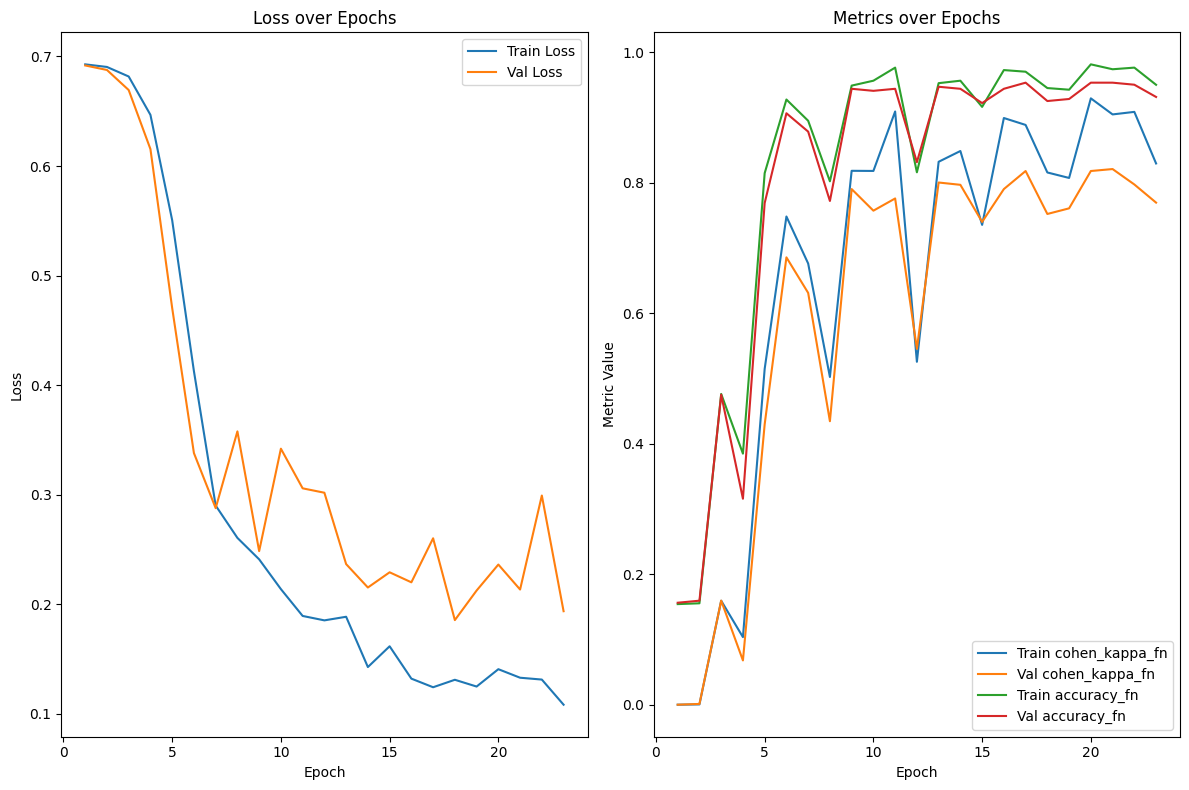

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1211 | Test cohen_kappa_fn: 0.8130 | Test accuracy_fn: 0.9458


#### Visualization

In [ ]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

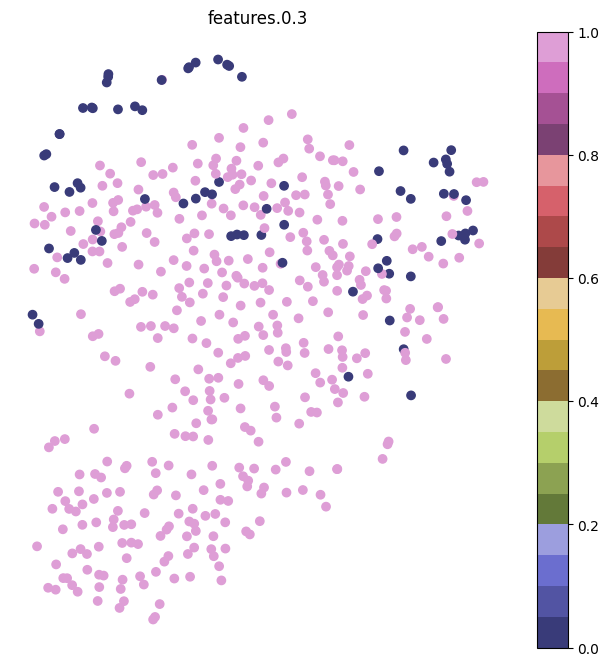

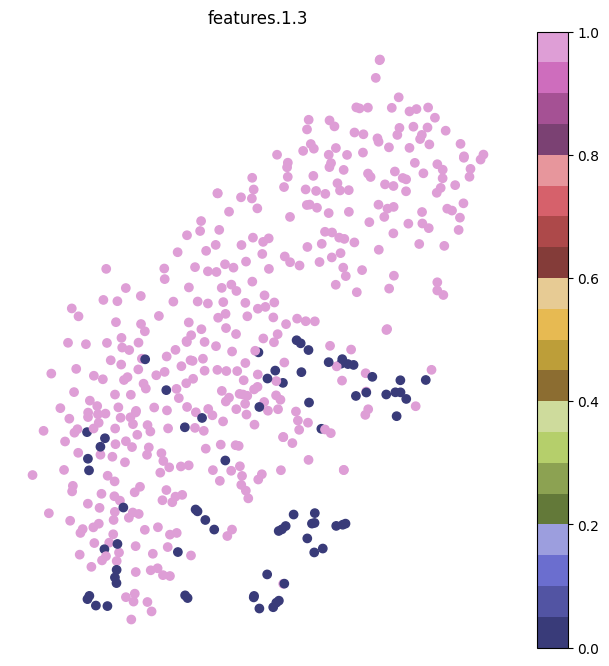

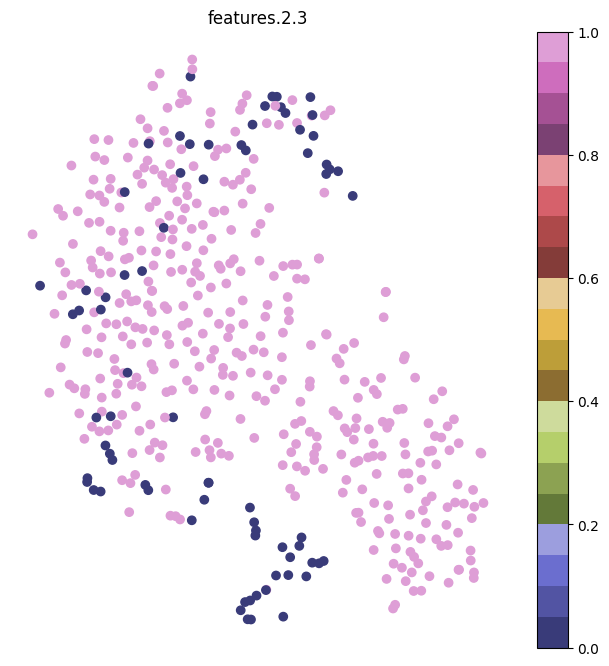

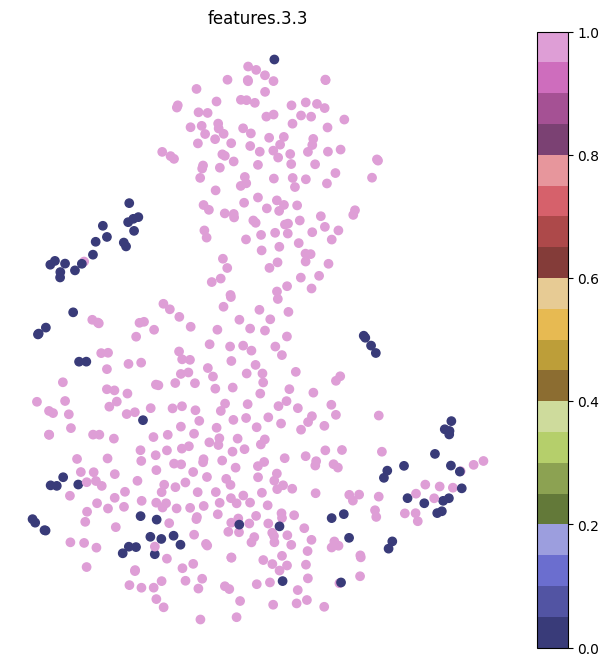

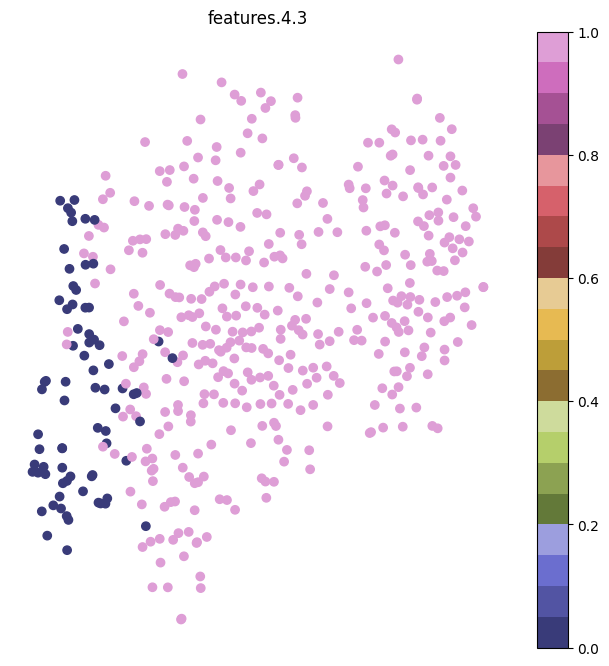

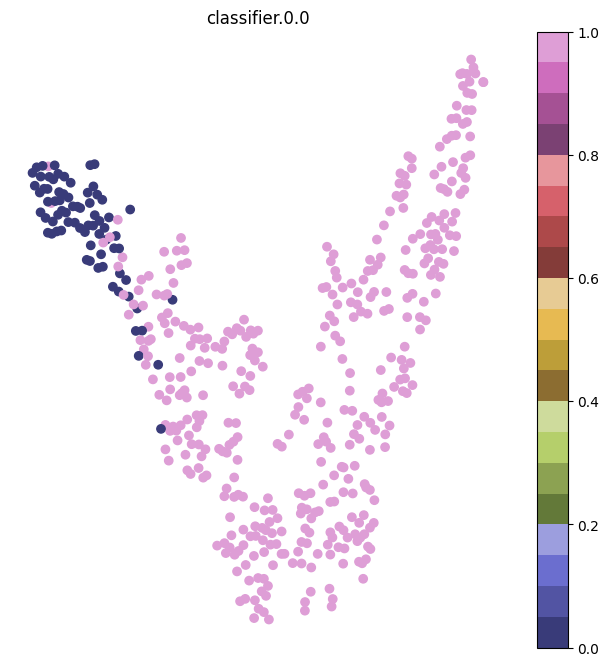

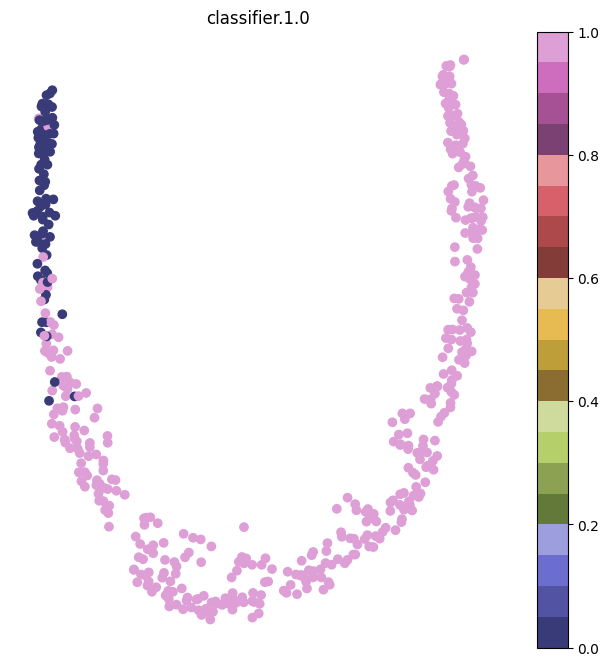

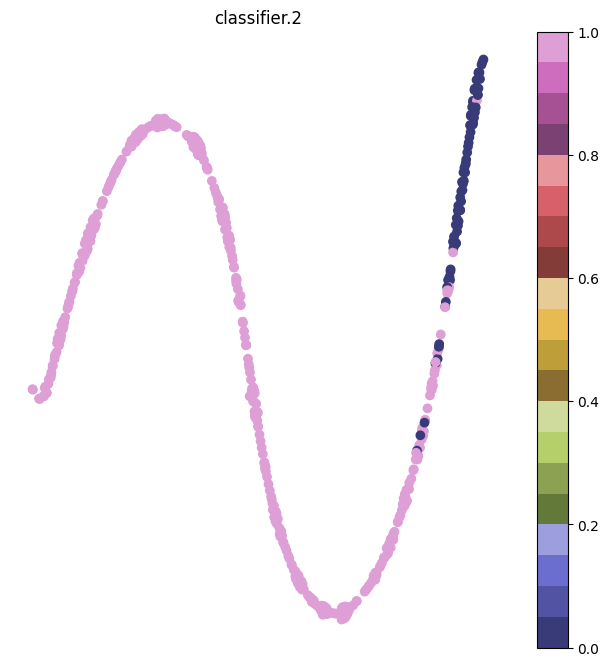

In [ ]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


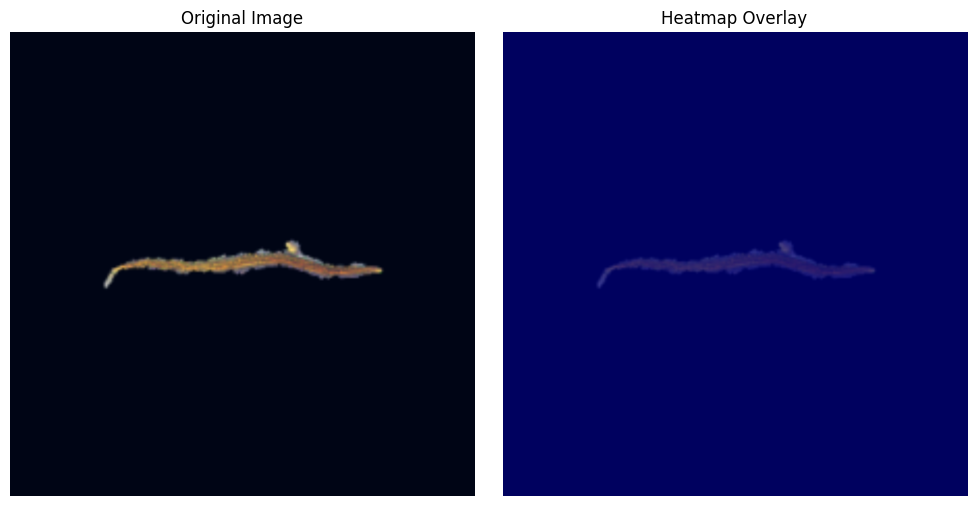

  Generating heatmap for Larvae...
  Predicted label is Larvae!


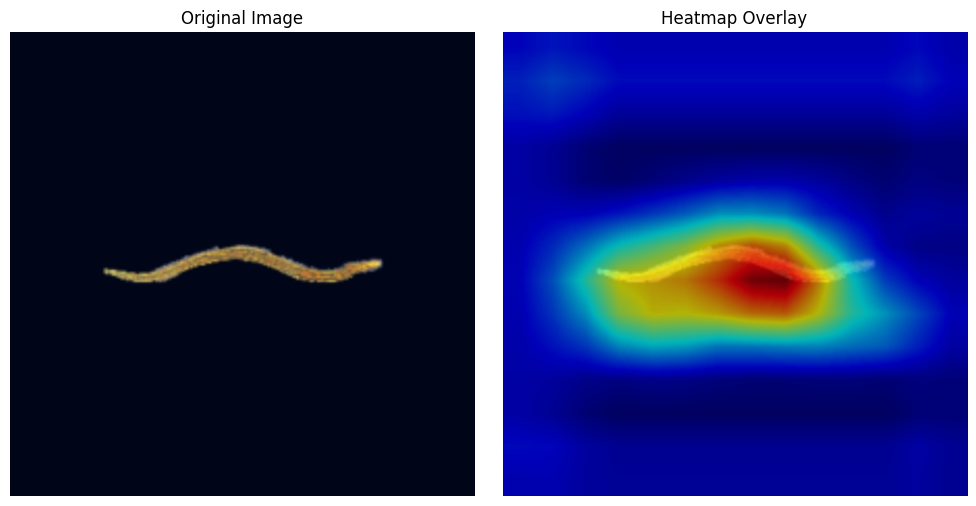

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [ ]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,8],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=eta_min)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6921 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6906 | Val Loss: 0.6857 | Train cohen_kappa_fn: 0.5090 | Val cohen_kappa_fn: 0.3517 | Train accuracy_fn: 0.8835 | Val accuracy_fn: 0.8625
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6736 | Val Loss: 0.6437 | Train cohen_kappa_fn: 0.3038 | Val cohen_kappa_fn: 0.2841 | Train accuracy_fn: 0.6754 | Val accuracy_fn: 0.6344
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5942 | Val Loss: 0.5085 | Train cohen_kappa_fn: 0.4178 | Val cohen_kappa_fn: 0.4058 | Train accuracy_fn: 0.7644 | Val accuracy_fn: 0.7437
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4370 | Val Loss: 0.3476 | Train cohen_kappa_fn: 0.5972 | Val cohen_kappa_fn: 0.5797 | Train accuracy_fn: 0.8622 | Val accuracy_fn: 0.8594
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3295 | Val Loss: 0.3232 | Train cohen_kappa_fn: 0.7927 | Val cohen_kappa_fn: 0.7419 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3010 | Val Loss: 0.2745 | Train cohen_kappa_fn: 0.6544 | Val cohen_kappa_fn: 0.6977 | Train accuracy_fn: 0.8847 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2264 | Val Loss: 0.2698 | Train cohen_kappa_fn: 0.5018 | Val cohen_kappa_fn: 0.5837 | Train accuracy_fn: 0.8058 | Val accuracy_fn: 0.8562
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1978 | Val Loss: 0.5815 | Train cohen_kappa_fn: 0.7791 | Val cohen_kappa_fn: 0.6169 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9187
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1986 | Val Loss: 0.2068 | Train cohen_kappa_fn: 0.6384 | Val cohen_kappa_fn: 0.7498 | Train accuracy_fn: 0.8759 | Val accuracy_fn: 0.9281
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1816 | Val Loss: 0.2663 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1494 | Val Loss: 0.2337 | Train cohen_kappa_fn: 0.7407 | Val cohen_kappa_fn: 0.8104 | Train accuracy_fn: 0.9198 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1442 | Val Loss: 0.3972 | Train cohen_kappa_fn: 0.8636 | Val cohen_kappa_fn: 0.6775 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9281
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1370 | Val Loss: 0.2233 | Train cohen_kappa_fn: 0.8821 | Val cohen_kappa_fn: 0.8530 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1477 | Val Loss: 0.3404 | Train cohen_kappa_fn: 0.8654 | Val cohen_kappa_fn: 0.8115 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


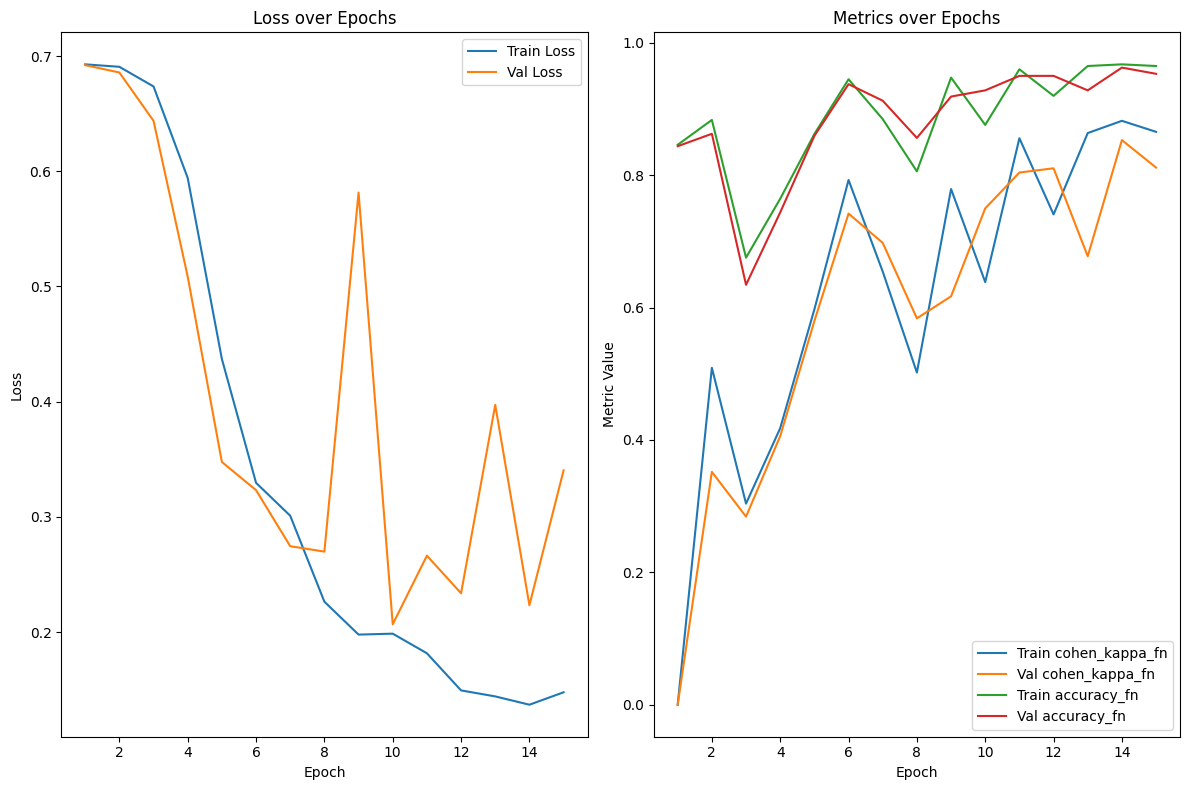

In [ ]:
trainer_cnn_4.plot_epochs()

In [ ]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1756 | Test cohen_kappa_fn: 0.8174 | Test accuracy_fn: 0.9479


#### Visualization

In [ ]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

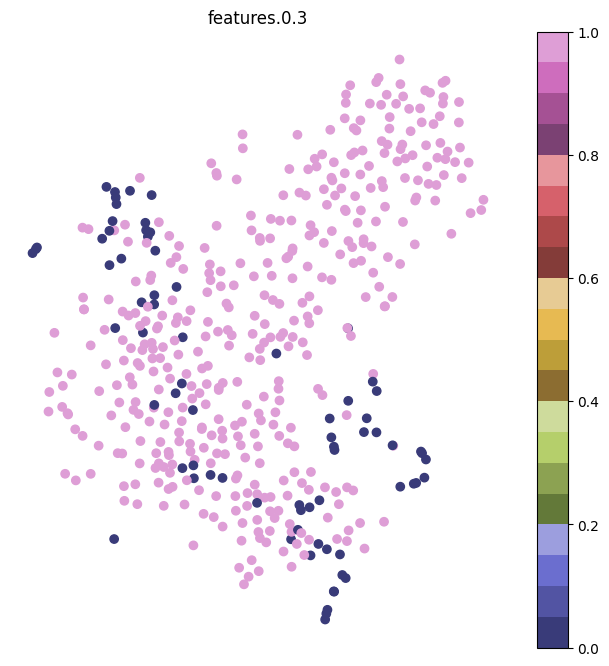

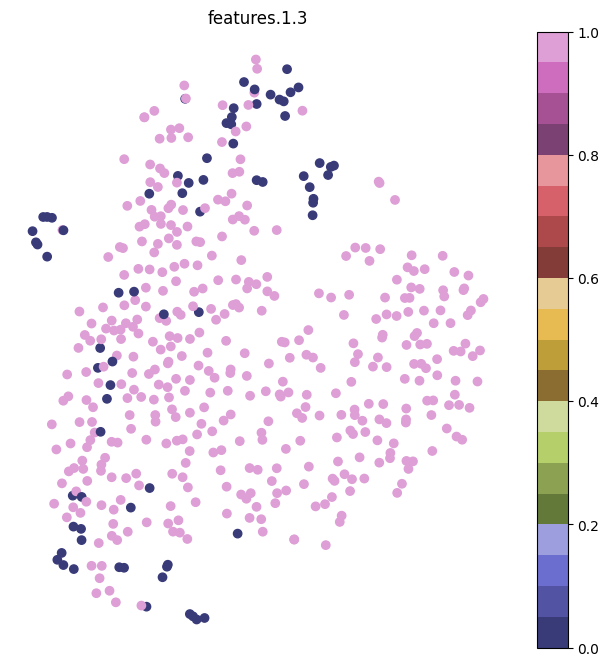

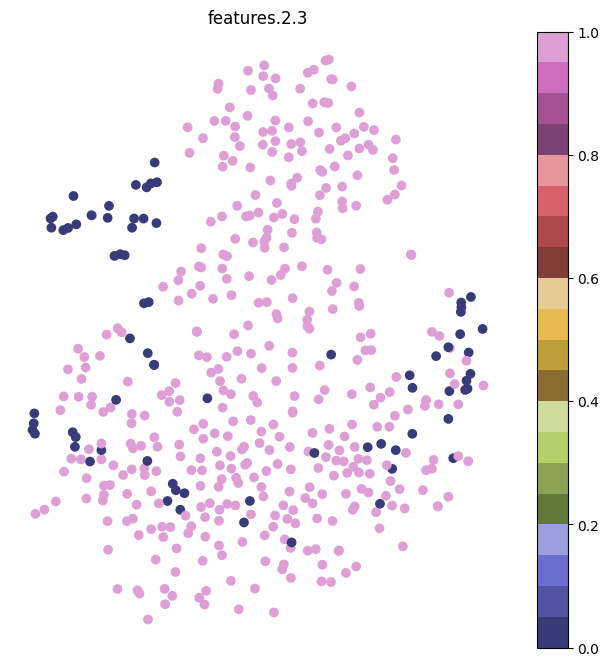

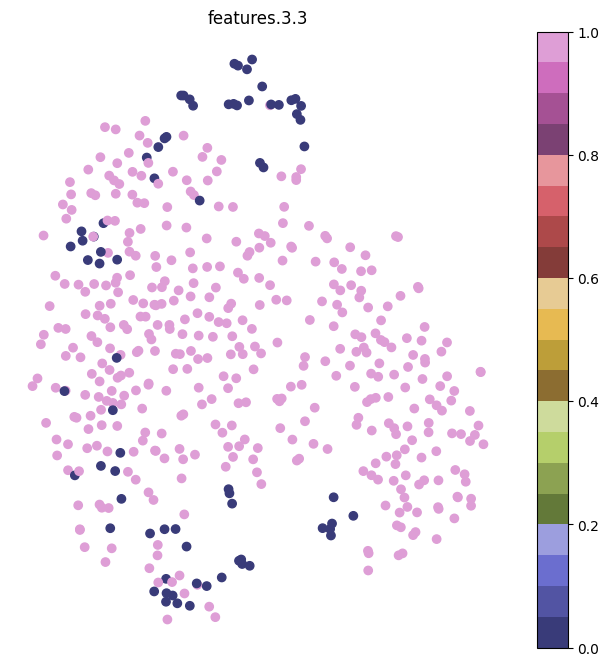

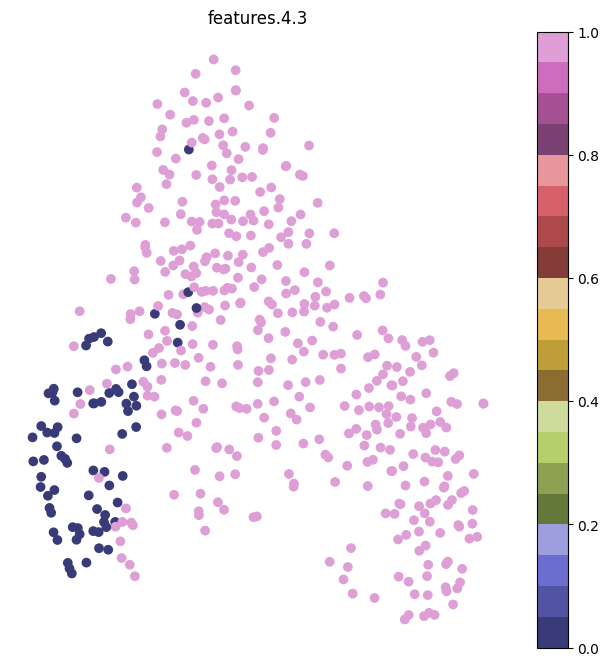

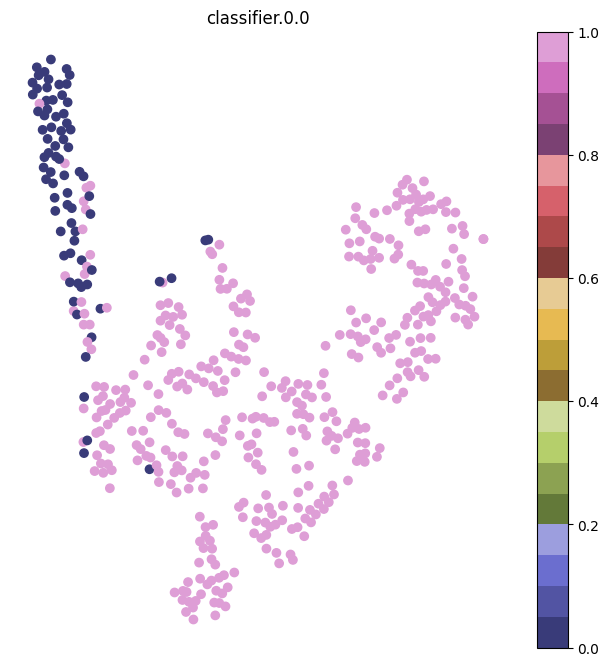

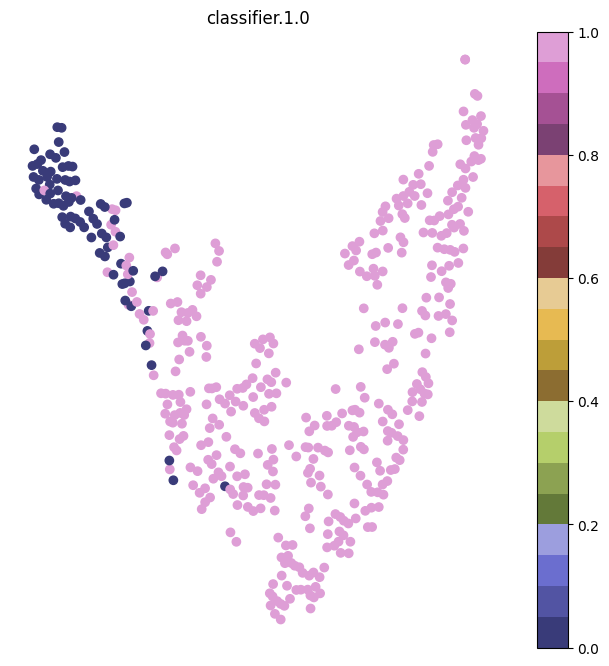

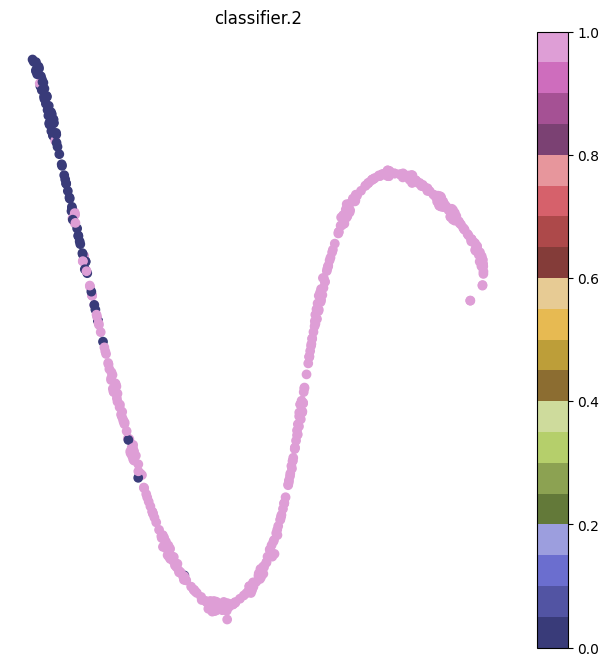

In [ ]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


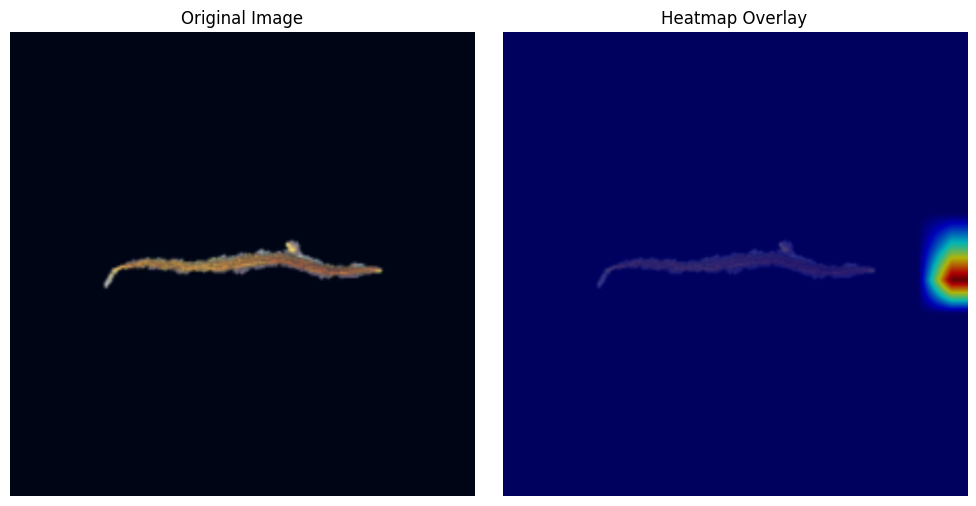

  Generating heatmap for Larvae...
  Predicted label is Larvae!


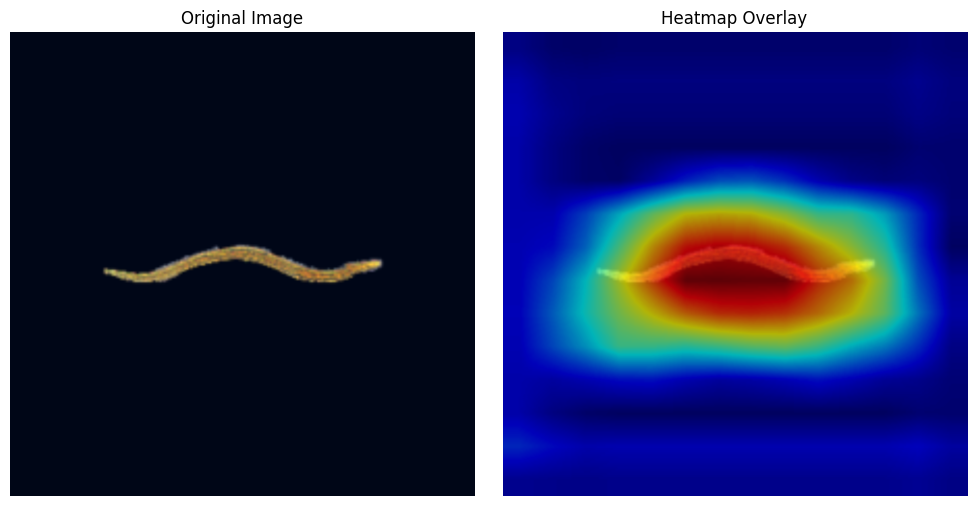

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [ ]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,16],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=eta_min)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6919 | Val Loss: 0.6902 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6850 | Val Loss: 0.6769 | Train cohen_kappa_fn: 0.3203 | Val cohen_kappa_fn: 0.3294 | Train accuracy_fn: 0.7055 | Val accuracy_fn: 0.7094
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6527 | Val Loss: 0.6113 | Train cohen_kappa_fn: 0.3527 | Val cohen_kappa_fn: 0.3526 | Train accuracy_fn: 0.7431 | Val accuracy_fn: 0.7375
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5673 | Val Loss: 0.4945 | Train cohen_kappa_fn: 0.3638 | Val cohen_kappa_fn: 0.3748 | Train accuracy_fn: 0.7293 | Val accuracy_fn: 0.7156
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4357 | Val Loss: 0.5932 | Train cohen_kappa_fn: 0.1406 | Val cohen_kappa_fn: 0.0868 | Train accuracy_fn: 0.4474 | Val accuracy_fn: 0.3531
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3518 | Val Loss: 0.2776 | Train cohen_kappa_fn: 0.7148 | Val cohen_kappa_fn: 0.6899 | Train accuracy_fn: 0.9135 | Val accuracy_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2691 | Val Loss: 0.2748 | Train cohen_kappa_fn: 0.6026 | Val cohen_kappa_fn: 0.5699 | Train accuracy_fn: 0.8609 | Val accuracy_fn: 0.8469
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2574 | Val Loss: 0.2350 | Train cohen_kappa_fn: 0.8419 | Val cohen_kappa_fn: 0.7795 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2381 | Val Loss: 0.2709 | Train cohen_kappa_fn: 0.5105 | Val cohen_kappa_fn: 0.5387 | Train accuracy_fn: 0.8083 | Val accuracy_fn: 0.8219
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1948 | Val Loss: 0.1967 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1846 | Val Loss: 0.1978 | Train cohen_kappa_fn: 0.8060 | Val cohen_kappa_fn: 0.7997 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1685 | Val Loss: 0.1901 | Train cohen_kappa_fn: 0.8814 | Val cohen_kappa_fn: 0.8255 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1373 | Val Loss: 0.2629 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1366 | Val Loss: 0.1696 | Train cohen_kappa_fn: 0.8026 | Val cohen_kappa_fn: 0.8367 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1423 | Val Loss: 0.5390 | Train cohen_kappa_fn: 0.2232 | Val cohen_kappa_fn: 0.2932 | Train accuracy_fn: 0.5652 | Val accuracy_fn: 0.6375
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1453 | Val Loss: 0.2891 | Train cohen_kappa_fn: 0.8936 | Val cohen_kappa_fn: 0.8082 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1103 | Val Loss: 0.1577 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.8367 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1102 | Val Loss: 0.4312 | Train cohen_kappa_fn: 0.9013 | Val cohen_kappa_fn: 0.7324 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1061 | Val Loss: 0.3198 | Train cohen_kappa_fn: 0.9282 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1035 | Val Loss: 0.3791 | Train cohen_kappa_fn: 0.3767 | Val cohen_kappa_fn: 0.3966 | Train accuracy_fn: 0.7143 | Val accuracy_fn: 0.7281
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1165 | Val Loss: 0.7051 | Train cohen_kappa_fn: 0.7986 | Val cohen_kappa_fn: 0.5290 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9031
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1319 | Val Loss: 0.2000 | Train cohen_kappa_fn: 0.6541 | Val cohen_kappa_fn: 0.6731 | Train accuracy_fn: 0.8822 | Val accuracy_fn: 0.8906
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


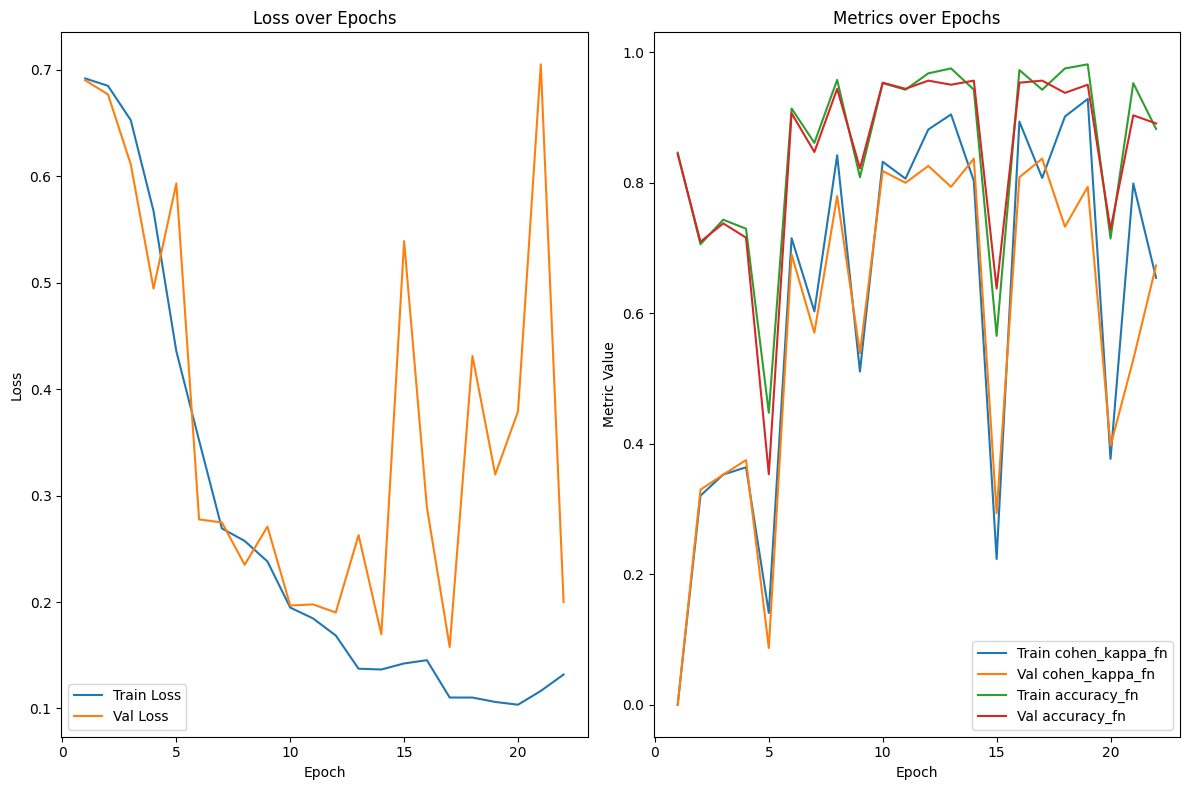

In [ ]:
trainer_cnn_5.plot_epochs()

In [ ]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1556 | Test cohen_kappa_fn: 0.8776 | Test accuracy_fn: 0.9667


#### Visualization

In [ ]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

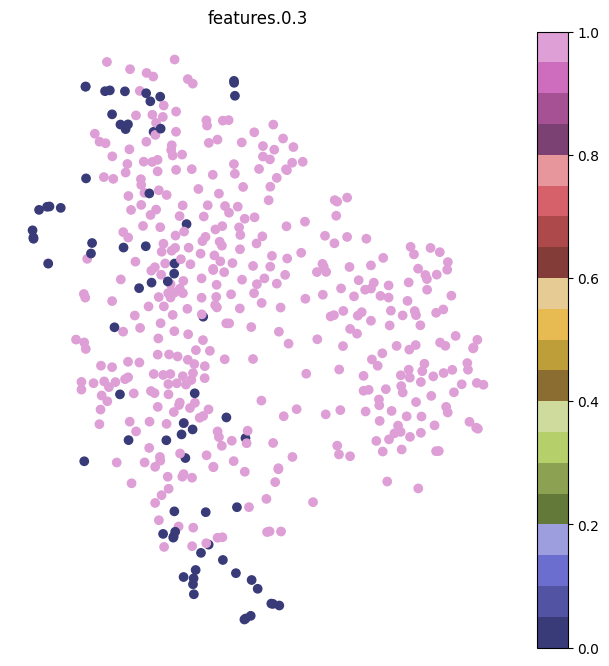

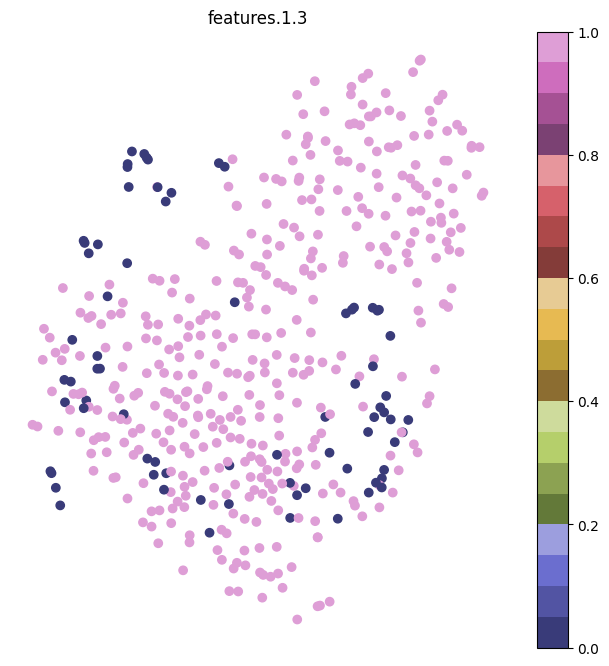

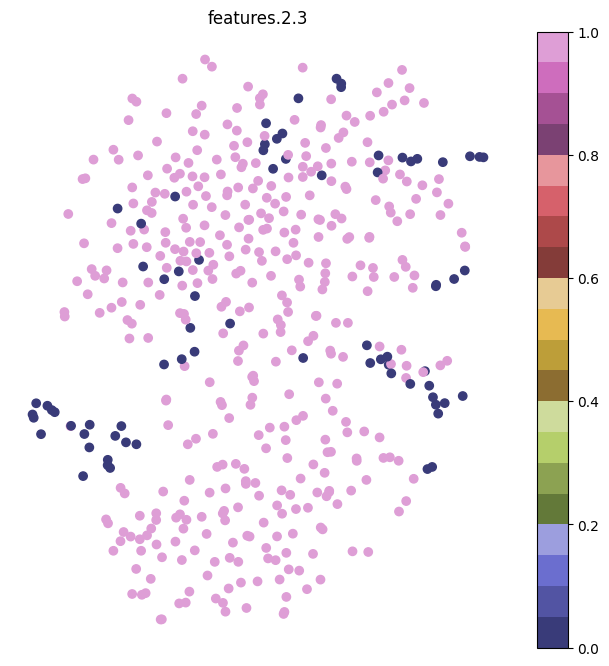

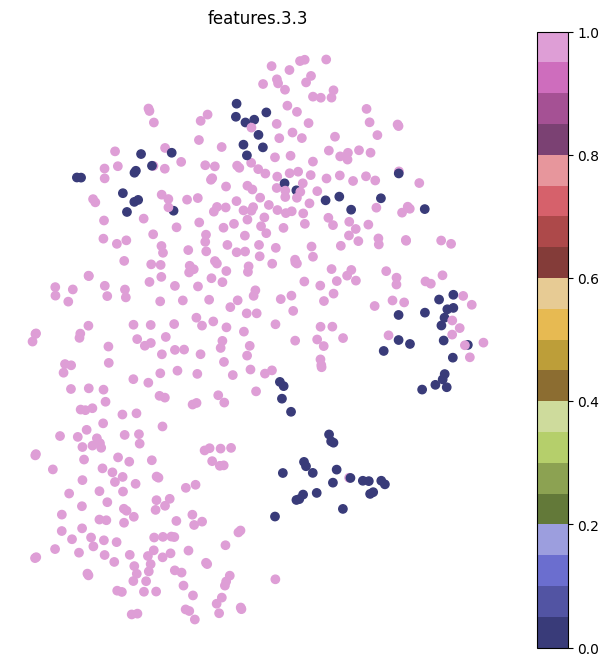

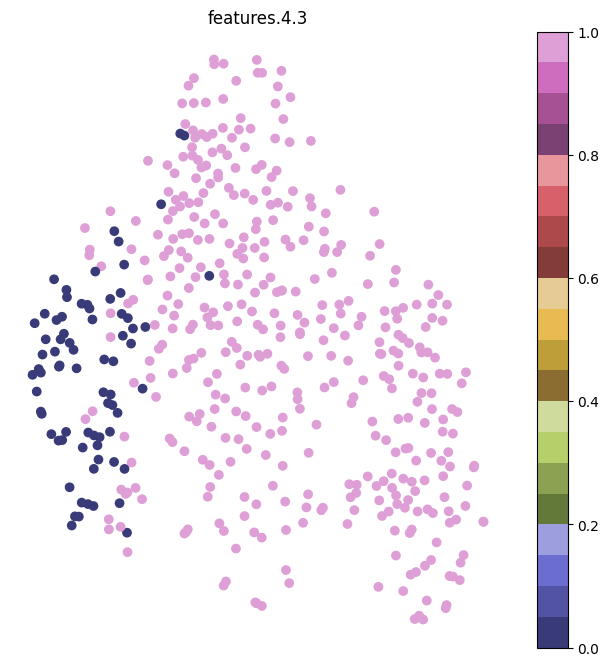

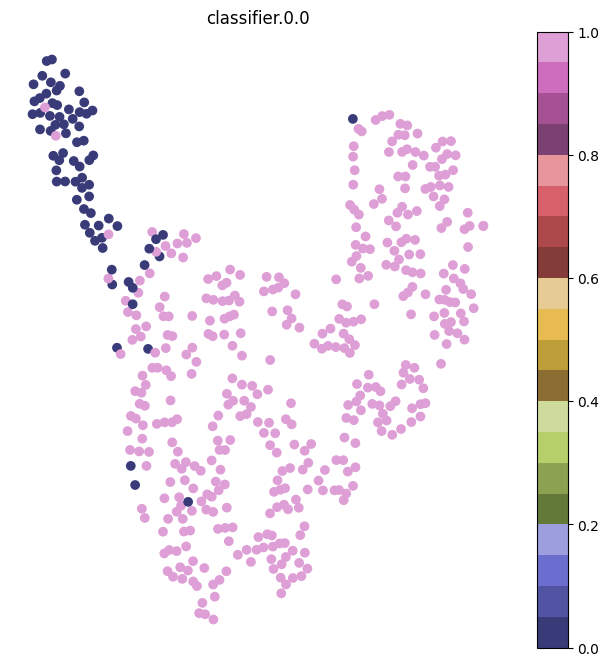

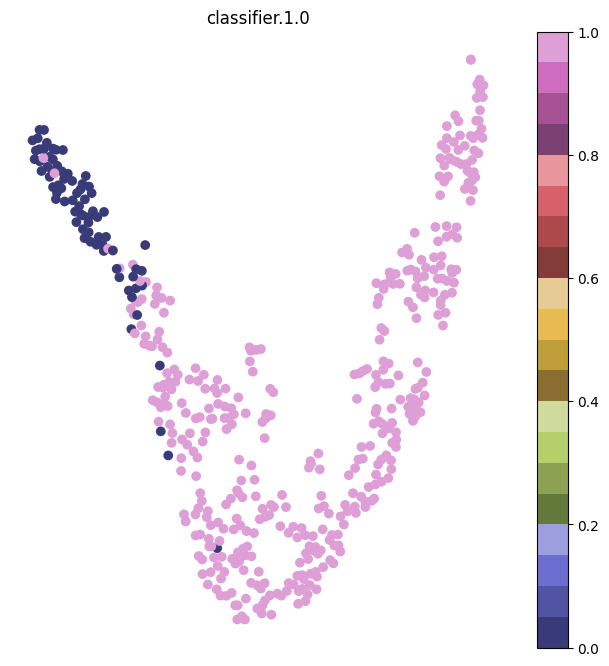

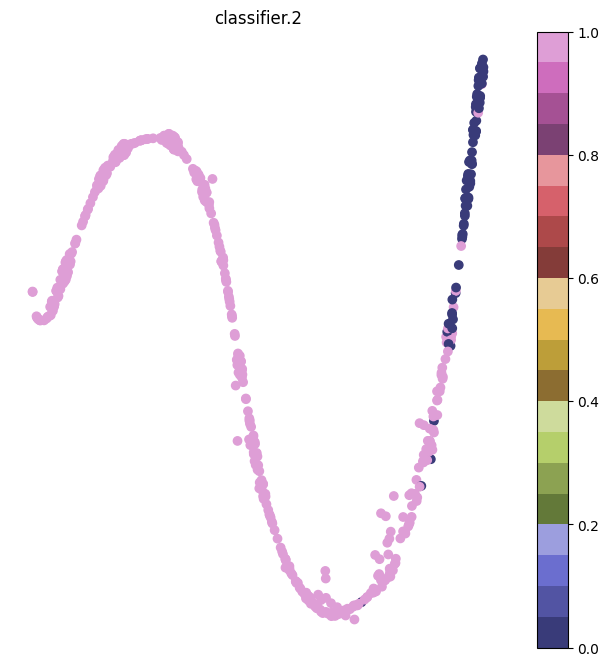

In [ ]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


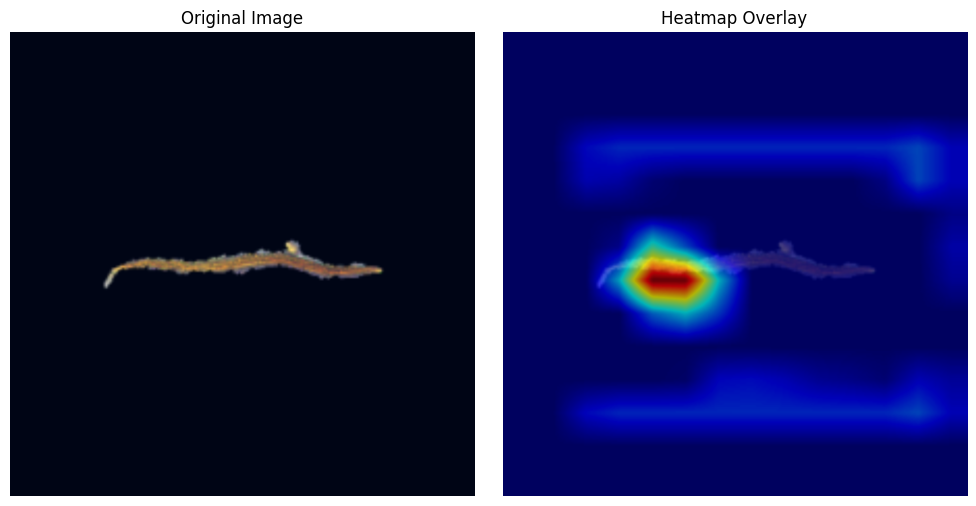

  Generating heatmap for Larvae...
  Predicted label is Larvae!


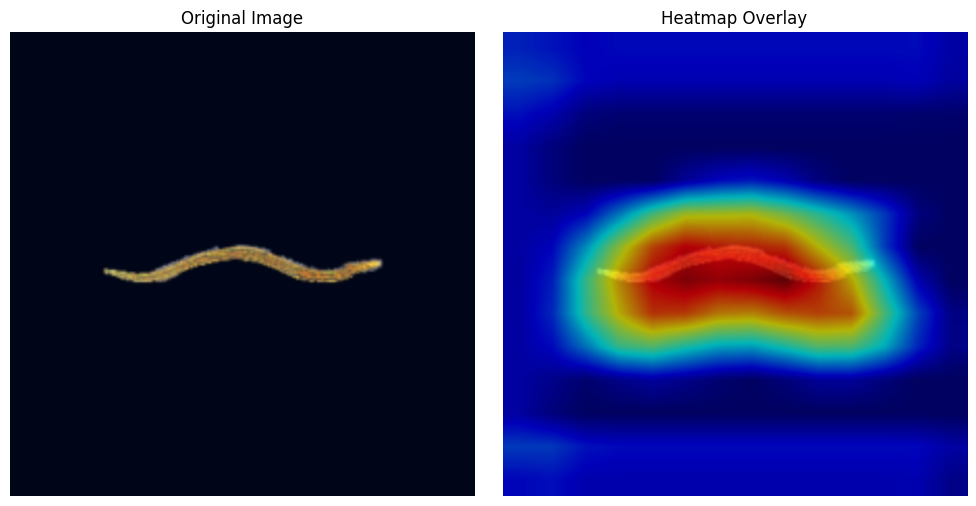

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [ ]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=eta_min)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6921 | Val Loss: 0.6903 | Train cohen_kappa_fn: 0.1219 | Val cohen_kappa_fn: -0.0122 | Train accuracy_fn: 0.8045 | Val accuracy_fn: 0.8375
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6835 | Val Loss: 0.6740 | Train cohen_kappa_fn: 0.3833 | Val cohen_kappa_fn: 0.2157 | Train accuracy_fn: 0.8296 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6537 | Val Loss: 0.6103 | Train cohen_kappa_fn: 0.4208 | Val cohen_kappa_fn: 0.3980 | Train accuracy_fn: 0.7982 | Val accuracy_fn: 0.8219
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5534 | Val Loss: 0.5252 | Train cohen_kappa_fn: 0.2038 | Val cohen_kappa_fn: 0.2014 | Train accuracy_fn: 0.5501 | Val accuracy_fn: 0.5406
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4354 | Val Loss: 0.4991 | Train cohen_kappa_fn: 0.2313 | Val cohen_kappa_fn: 0.1813 | Train accuracy_fn: 0.5777 | Val accuracy_fn: 0.5063
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3506 | Val Loss: 0.2935 | Train cohen_kappa_fn: 0.6179 | Val cohen_kappa_fn: 0.6225 | Train accuracy_fn: 0.8772 | Val accuracy_fn: 0.8875
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3180 | Val Loss: 0.3041 | Train cohen_kappa_fn: 0.5420 | Val cohen_kappa_fn: 0.6053 | Train accuracy_fn: 0.8333 | Val accuracy_fn: 0.8781
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2614 | Val Loss: 0.2741 | Train cohen_kappa_fn: 0.7215 | Val cohen_kappa_fn: 0.7590 | Train accuracy_fn: 0.9160 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2508 | Val Loss: 0.2732 | Train cohen_kappa_fn: 0.7420 | Val cohen_kappa_fn: 0.7531 | Train accuracy_fn: 0.9236 | Val accuracy_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2310 | Val Loss: 0.2867 | Train cohen_kappa_fn: 0.7674 | Val cohen_kappa_fn: 0.7630 | Train accuracy_fn: 0.9311 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1951 | Val Loss: 0.2830 | Train cohen_kappa_fn: 0.7568 | Val cohen_kappa_fn: 0.7245 | Train accuracy_fn: 0.9273 | Val accuracy_fn: 0.9250
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1949 | Val Loss: 0.3334 | Train cohen_kappa_fn: 0.8605 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1936 | Val Loss: 0.2430 | Train cohen_kappa_fn: 0.6665 | Val cohen_kappa_fn: 0.6357 | Train accuracy_fn: 0.8885 | Val accuracy_fn: 0.8844
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1713 | Val Loss: 0.2367 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.7704 | Train accuracy_fn: 0.9211 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1644 | Val Loss: 0.2915 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.7653 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1503 | Val Loss: 0.4146 | Train cohen_kappa_fn: 0.9058 | Val cohen_kappa_fn: 0.7373 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1422 | Val Loss: 0.3007 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.7508 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1279 | Val Loss: 0.2119 | Train cohen_kappa_fn: 0.7417 | Val cohen_kappa_fn: 0.7409 | Train accuracy_fn: 0.9185 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1433 | Val Loss: 0.2608 | Train cohen_kappa_fn: 0.8590 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1248 | Val Loss: 0.2490 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1282 | Val Loss: 0.3285 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.7826 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0984 | Val Loss: 0.2219 | Train cohen_kappa_fn: 0.8455 | Val cohen_kappa_fn: 0.8208 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1302 | Val Loss: 0.1991 | Train cohen_kappa_fn: 0.7787 | Val cohen_kappa_fn: 0.7775 | Train accuracy_fn: 0.9323 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1259 | Val Loss: 0.1780 | Train cohen_kappa_fn: 0.7697 | Val cohen_kappa_fn: 0.7902 | Train accuracy_fn: 0.9286 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.0938 | Val Loss: 0.3844 | Train cohen_kappa_fn: 0.9332 | Val cohen_kappa_fn: 0.7677 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0822 | Val Loss: 0.1827 | Train cohen_kappa_fn: 0.8417 | Val cohen_kappa_fn: 0.8094 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.0866 | Val Loss: 0.2071 | Train cohen_kappa_fn: 0.8545 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9586 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.0909 | Val Loss: 0.2547 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0959 | Val Loss: 0.3562 | Train cohen_kappa_fn: 0.8983 | Val cohen_kappa_fn: 0.7677 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


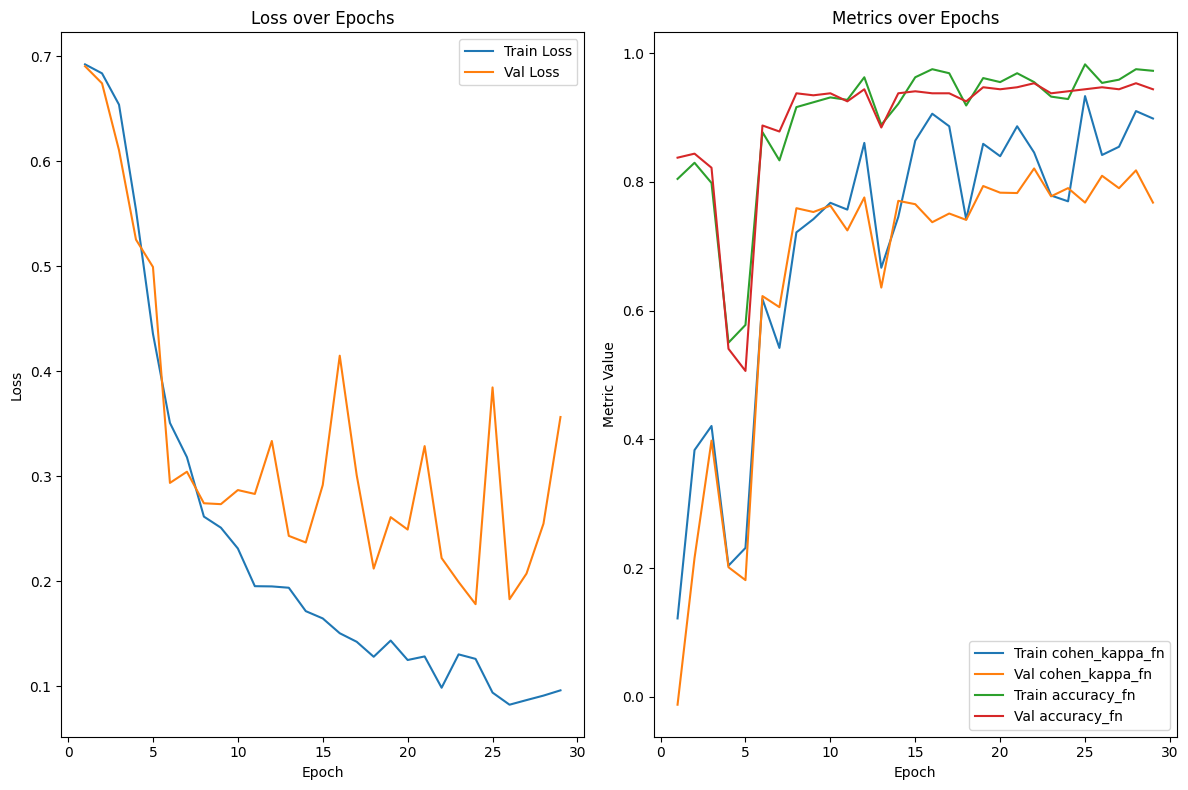

In [ ]:
trainer_cnn_6.plot_epochs()

In [ ]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1837 | Test cohen_kappa_fn: 0.7426 | Test accuracy_fn: 0.9292


#### Visualization

In [ ]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

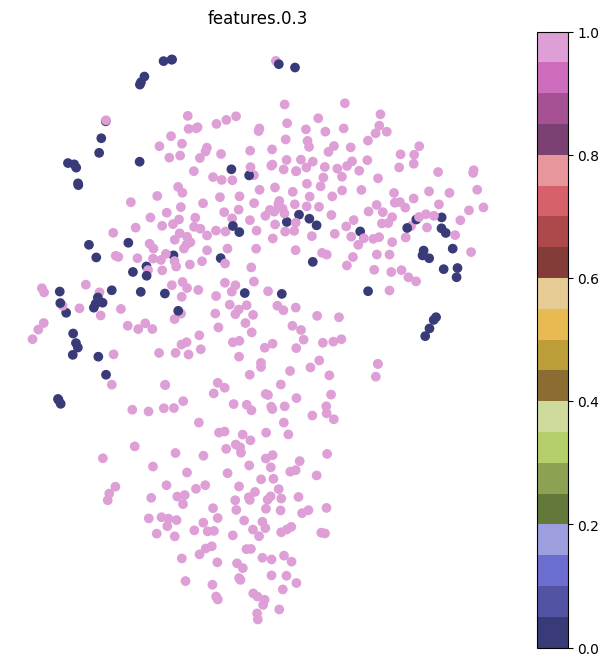

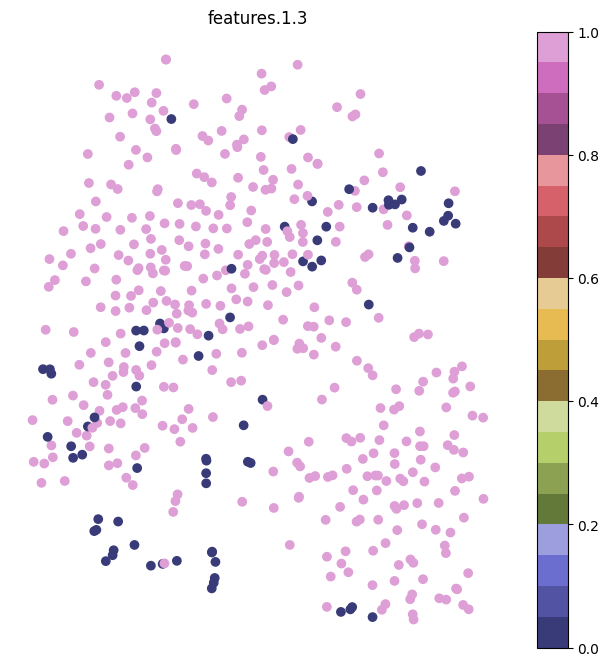

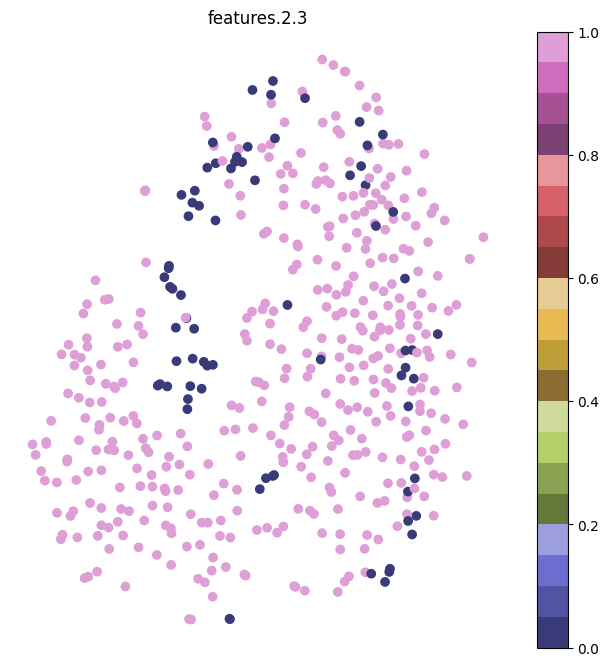

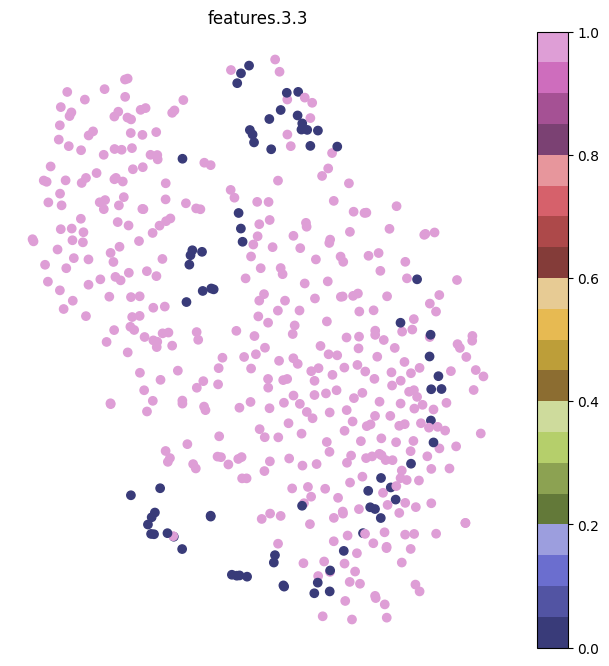

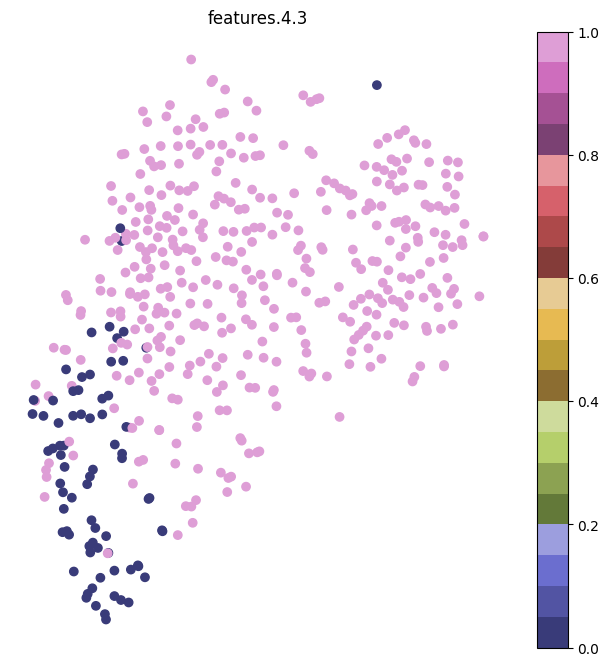

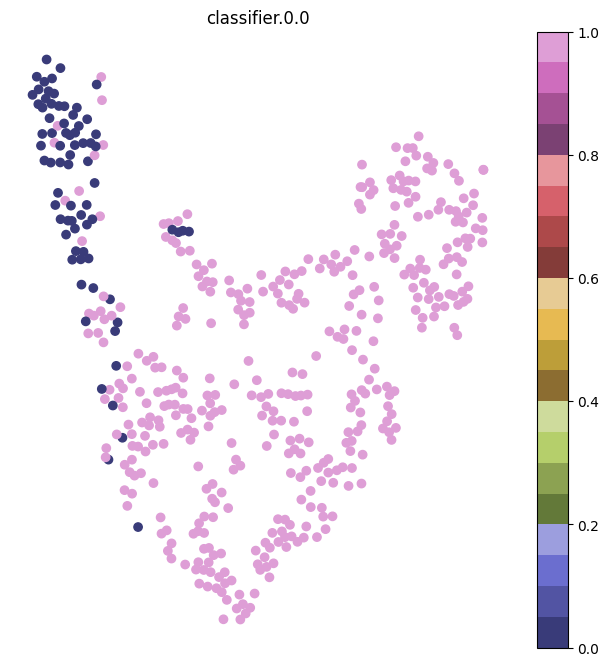

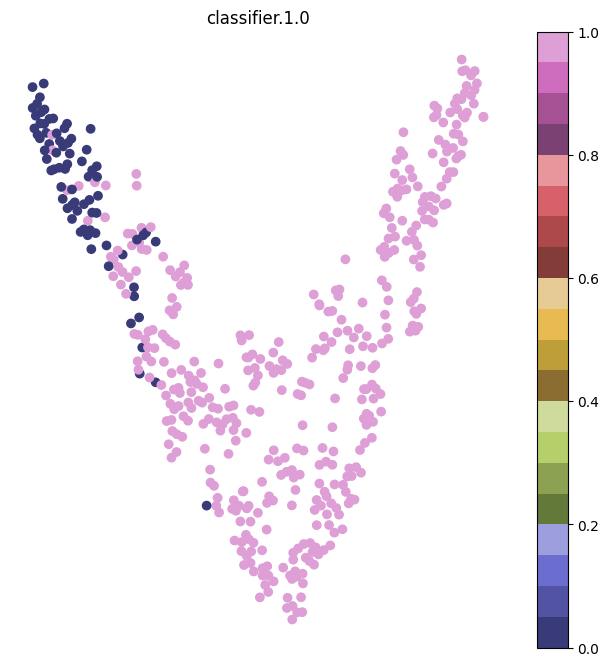

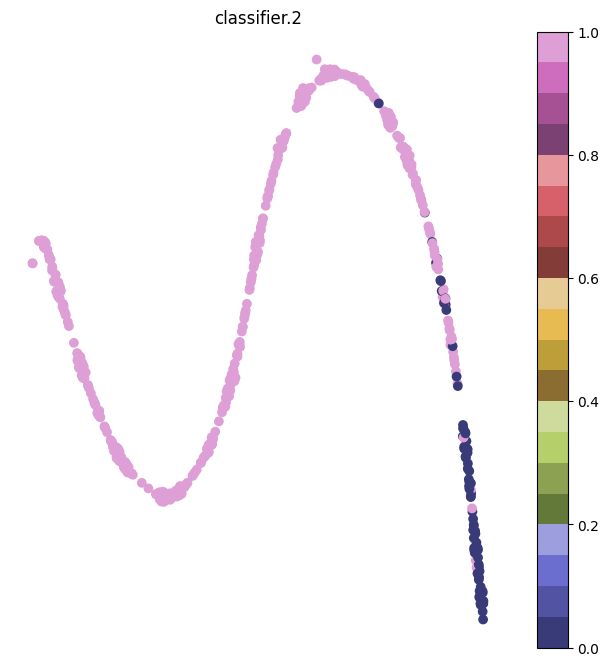

In [ ]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


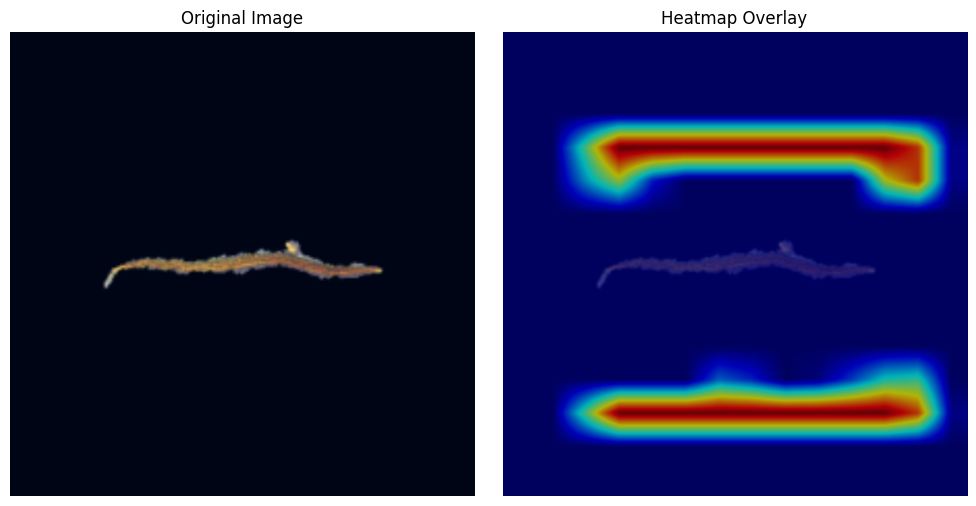

  Generating heatmap for Larvae...
  Predicted label is Larvae!


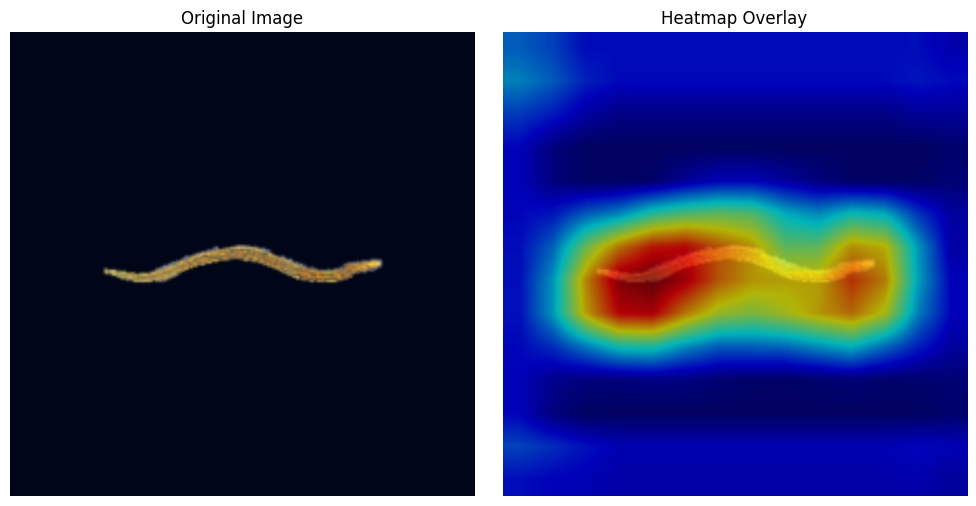

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [ ]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[256],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=eta_min)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6927 | Val Loss: 0.6911 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 2 | Train Loss: 0.6870 | Val Loss: 0.6820 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 3 | Train Loss: 0.6645 | Val Loss: 0.6428 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6103 | Val Loss: 0.6068 | Train cohen_kappa_fn: 0.5141 | Val cohen_kappa_fn: 0.4506 | Train accuracy_fn: 0.8409 | Val accuracy_fn: 0.7937
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5606 | Val Loss: 0.5930 | Train cohen_kappa_fn: 0.4756 | Val cohen_kappa_fn: 0.3894 | Train accuracy_fn: 0.7982 | Val accuracy_fn: 0.7406
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5042 | Val Loss: 0.5795 | Train cohen_kappa_fn: 0.3567 | Val cohen_kappa_fn: 0.2749 | Train accuracy_fn: 0.7018 | Val accuracy_fn: 0.6250
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4414 | Val Loss: 0.5154 | Train cohen_kappa_fn: 0.3057 | Val cohen_kappa_fn: 0.2342 | Train accuracy_fn: 0.6516 | Val accuracy_fn: 0.5875
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3791 | Val Loss: 0.3649 | Train cohen_kappa_fn: 0.7900 | Val cohen_kappa_fn: 0.7405 | Train accuracy_fn: 0.9436 | Val accuracy_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3328 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.7341 | Val cohen_kappa_fn: 0.6818 | Train accuracy_fn: 0.9173 | Val accuracy_fn: 0.9031
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2843 | Val Loss: 0.3446 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.7508 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2450 | Val Loss: 0.2441 | Train cohen_kappa_fn: 0.8428 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2456 | Val Loss: 0.4078 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7057 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2295 | Val Loss: 0.2477 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7730 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2272 | Val Loss: 0.3069 | Train cohen_kappa_fn: 0.8810 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2082 | Val Loss: 0.3268 | Train cohen_kappa_fn: 0.9001 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1920 | Val Loss: 0.2009 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.8001 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1785 | Val Loss: 0.2002 | Train cohen_kappa_fn: 0.6348 | Val cohen_kappa_fn: 0.7224 | Train accuracy_fn: 0.8734 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1980 | Val Loss: 0.4426 | Train cohen_kappa_fn: 0.8716 | Val cohen_kappa_fn: 0.7481 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1594 | Val Loss: 0.1977 | Train cohen_kappa_fn: 0.8218 | Val cohen_kappa_fn: 0.8033 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2134 | Val Loss: 0.2599 | Train cohen_kappa_fn: 0.4897 | Val cohen_kappa_fn: 0.5680 | Train accuracy_fn: 0.7957 | Val accuracy_fn: 0.8406
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2017 | Val Loss: 0.5919 | Train cohen_kappa_fn: 0.8563 | Val cohen_kappa_fn: 0.7002 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1614 | Val Loss: 0.2157 | Train cohen_kappa_fn: 0.8821 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1604 | Val Loss: 0.2266 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9586 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1529 | Val Loss: 0.4069 | Train cohen_kappa_fn: 0.2806 | Val cohen_kappa_fn: 0.4074 | Train accuracy_fn: 0.6266 | Val accuracy_fn: 0.7406
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


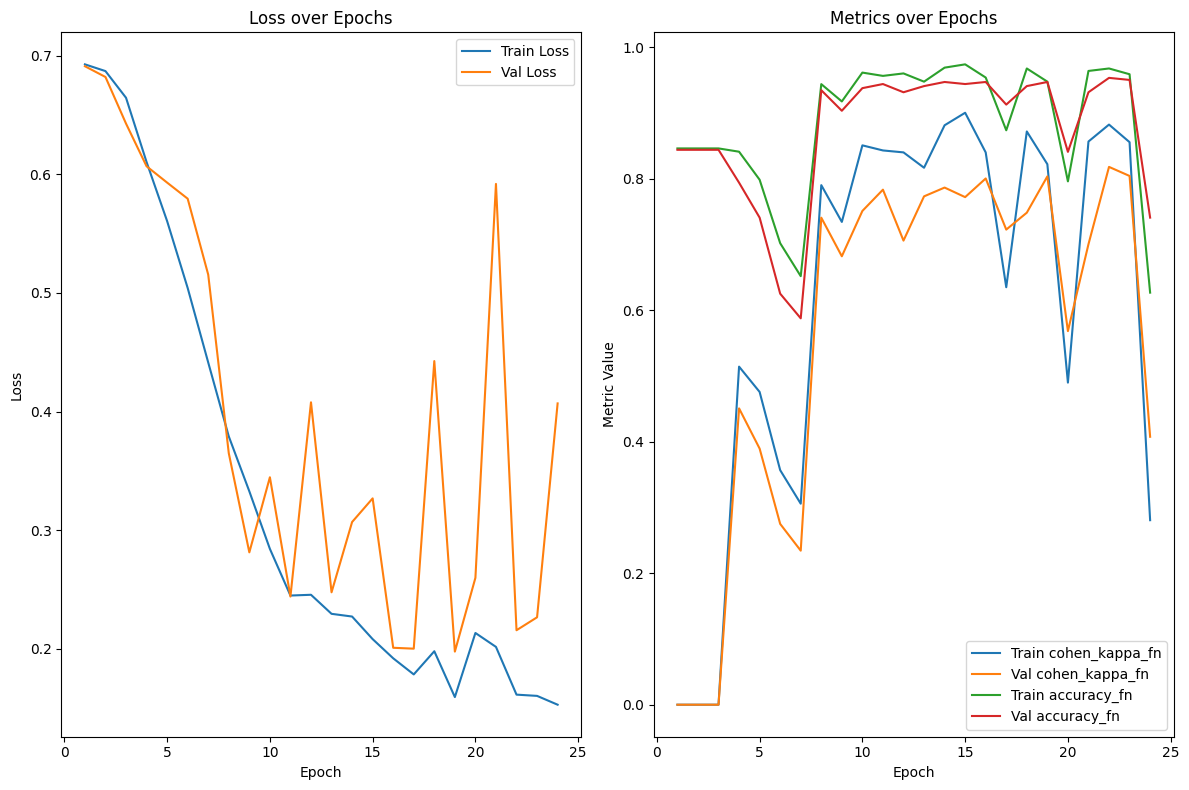

In [ ]:
trainer_cnn_7.plot_epochs()

In [ ]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1579 | Test cohen_kappa_fn: 0.8454 | Test accuracy_fn: 0.9583


#### Visualization

In [ ]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

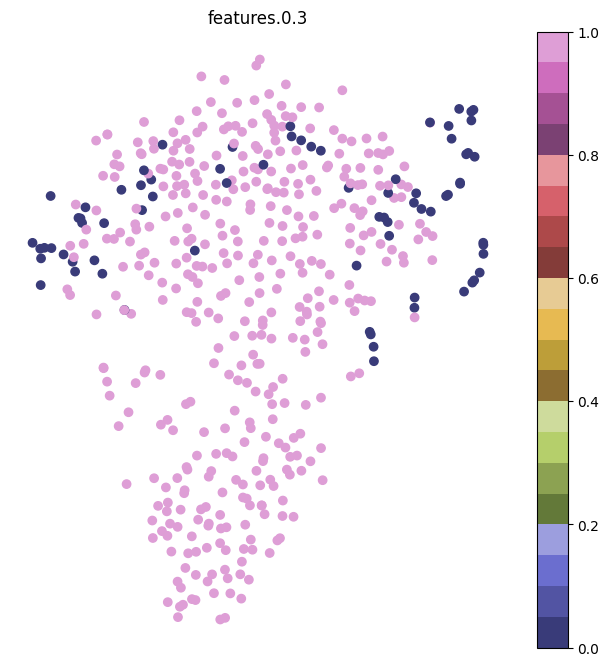

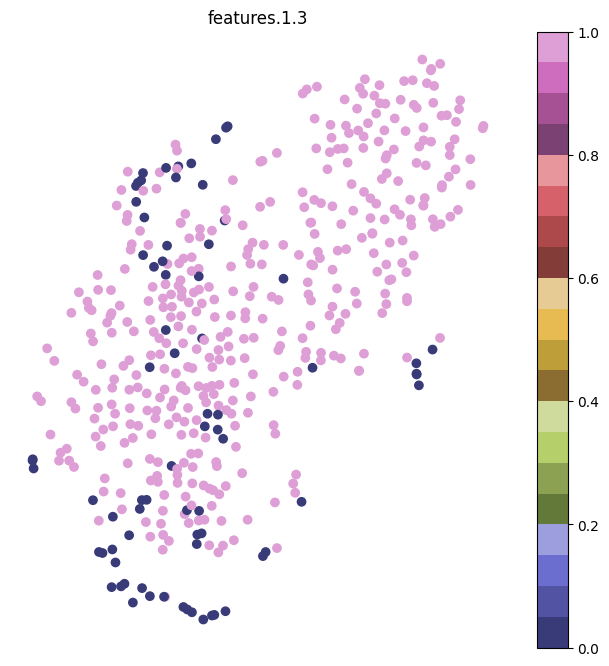

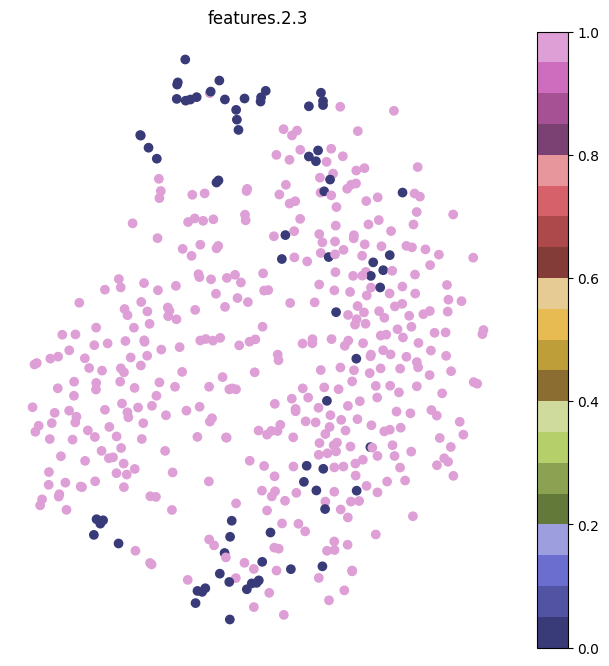

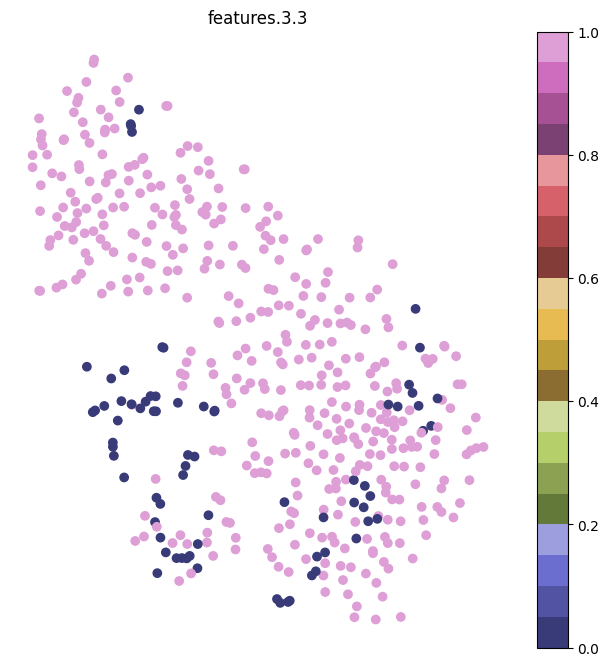

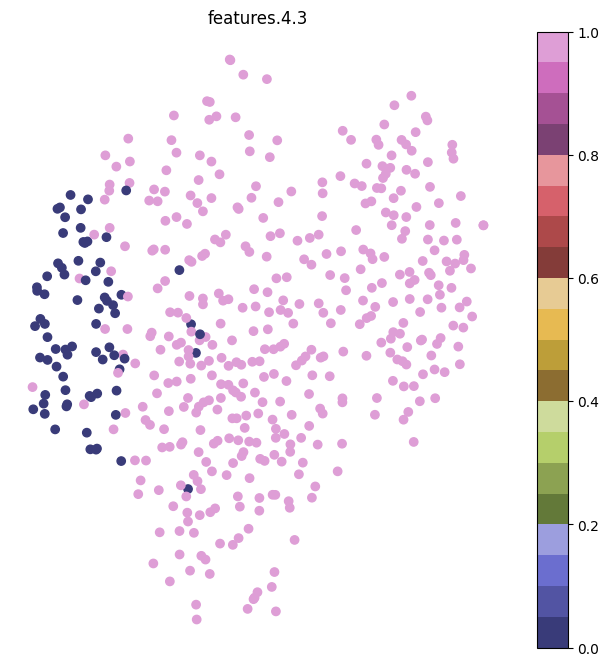

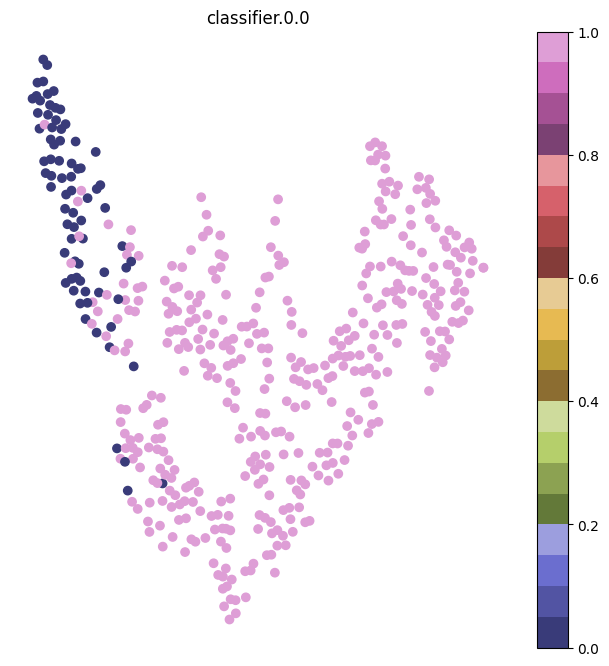

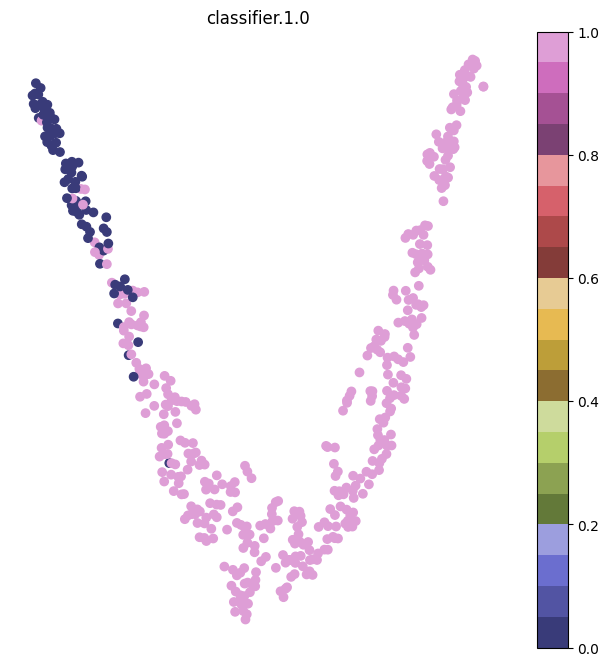

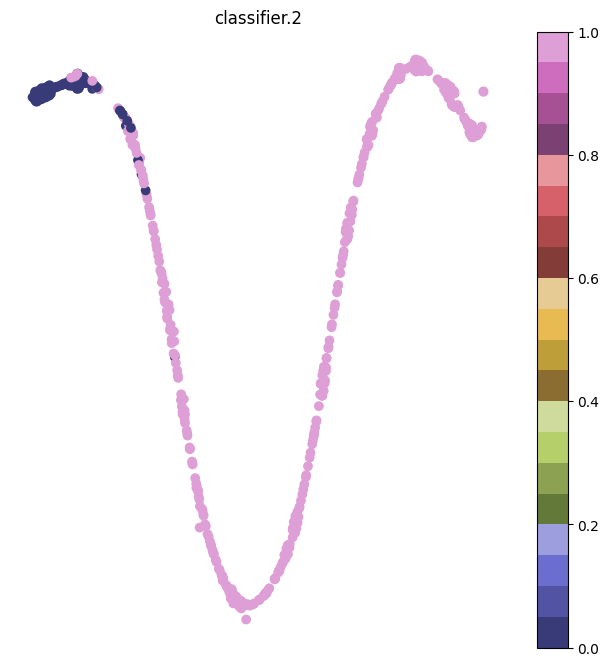

In [ ]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


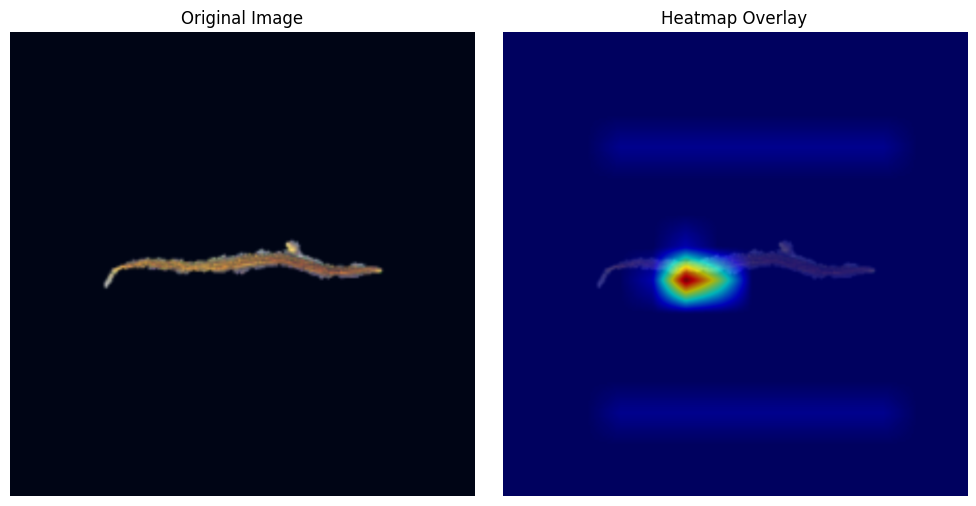

  Generating heatmap for Larvae...
  Predicted label is Larvae!


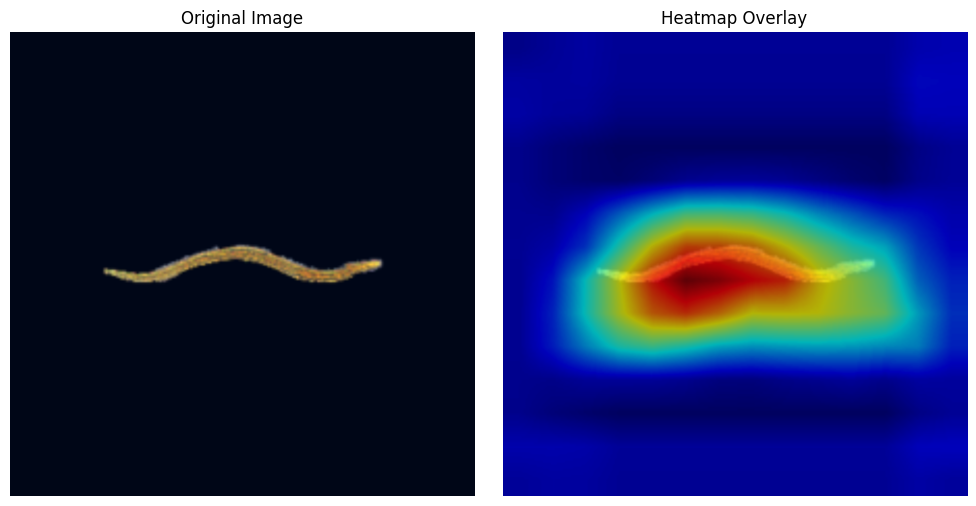

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break